In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import scipy.cluster.hierarchy as sch
import datetime as dt
import statsmodels.api as smi
import statsmodels.stats.weightstats as sw
import scipy.stats as stats
import pingouin as pg

from matplotlib.collections import LineCollection
from sklearn import decomposition, preprocessing, cluster
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d, proj3d
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import kstest

import unicodedata2 as ud
import re

c:\workplace\data_env\lib\site-packages\outdated\utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
ind_conso = pd.read_csv('ind_conso_alim.csv')
prix_prod = pd.read_csv('prix_production.csv')
bilan_alim = pd.read_csv('bilan_alim.csv')
donnee_alim = pd.read_csv('donnee_alim.csv')
donnee_prot = pd.read_csv('donne_prot.csv')
ind_prod = pd.read_csv('indice_prod.csv')
ipc = pd.read_csv('ipc.csv')
pib = pd.read_csv('pib_croissance.csv')
pop = pd.read_csv('pop.csv')
nomenclature = pd.read_csv('nomenclatures_pays.csv')

In [4]:
# "le précieuuuux", "pour les yeuuuux"
plt.style.use('bmh')
mpl.rcParams['axes.edgecolor'] = 'lightslategray'
mpl.rcParams['figure.facecolor'] = 'lightgrey'

tps_ss = dt.datetime.now()
if (tps_ss.hour, tps_ss.minute) < (7, 00) or (tps_ss.hour, tps_ss.minute) > (21, 20):
    plt.style.use('dark_background')

#### Plan  
  
1. Nettoyage  
    1.1 Réunion des datasets  
    1.2 Nettoyage des valeurs NaN et sémantiques  
    1.3 Calcul de données à exploiter  
    1.4 Pivot_table  
  
2. Dendrogramme  
    2.1 Construction des groupes  
    2.2 Caractéristiques des clusters  
    2.3 K-means et centroïdes  
  
3. Tests  
    3.1 Sélection d'une variable témoin  
    3.2 Test de différentiation

#### **1. Nettoyage**  

**1.1 Réunion des datasets**  
      
Certaines données sont disponibles mensuellement, nous retenons janvier comme mois de référence.  
Les intitulés de colonnes diffèrent selon les datatsets, nous les réunissons par typographie, modifions les noms puis concaténons l'ensemble des données dans un même df.

In [5]:
bdd_a = pd.concat([donnee_alim, donnee_prot, ind_conso[ind_conso.Mois == 'Janvier'], prix_prod, bilan_alim, pop])
bdd_b = pd.concat([ipc[ipc.Mois == 'Janvier'], pib])

In [6]:
# renommage des colonnes
bdd_a.rename(columns = {
    'Ann?e' : 'annee',
    'Unit?' : 'unite', 
    '?l?ment' : 'element'},
    inplace = True)
bdd_b.rename(columns = {
    'Élément' : 'element',
    'Année' : 'annee',
    'Unité' : 'unite'},
    inplace = True)

In [7]:
bdd_market_brut = pd.concat([bdd_a, bdd_b])

In [8]:
bdd_market_brut.rename(columns = {
    'Code zone (M49)' : 'code_m49',
    'Zone' : 'zone',
    'Produit' : 'produit',
    'Valeur' : 'valeur',
    'Code zone (FAO)' : 'code_zone'},
    inplace = True)

In [9]:
bdd_market_ = bdd_market_brut[['zone', 'code_zone', 'code_m49', 'annee', 'produit', 'element', 'valeur', 'unite']]
bdd_market_.reset_index(drop = True, inplace = True)

**1.2 Nettoyage des valeurs NaN et sémantiques**  
  
Nous passons au nettoyage des valeurs NaN. La colonne code_m49 a été conservée pour pouvoir traiter les valeurs manquantes de 'code_zone et sera supprimée par la suite. Nous commençons par créer un dictionnaire de nomenclature Dico_zone et remplaçons les valeurs manquantes de Code_zone.

In [10]:
# sauvegarde du code FAO de la Chine
code_chine = nomenclature[nomenclature.Pays == 'Chine']

In [11]:
# nettoyage des valeurs NaN du df Nomenclature
idx = nomenclature[nomenclature['Code M49'].isna()].index
nomenclature.drop(idx, inplace = True)

In [12]:
# extraction des données visées
dico_zone_ = nomenclature[['Pays', 'Code Pays', 'Code M49']]
dico_zone = dico_zone_.drop_duplicates('Pays')

In [13]:
nomenclature.columns = ['code_fao', 'pays', 'code_m49', 'code_iso2', 'code_iso3', 'anne_debut', 'ano_inicio']
nomenclature.drop_duplicates(inplace = True)
nomenclature.insert(0, 'pays', nomenclature.pop('pays'))
nomenclature.to_csv('nomenclature_pays.csv', index = False)

In [12]:
# colonnes de dico_zone renommées
dico_zone.columns = ['pays', 'code_zone', 'code_m49']

In [13]:
# présence simultanée de valeurs NaN dans code_zone et code_m49?
bdd_market_[(bdd_market_.code_zone.isna()) & (bdd_market_.code_m49.isna())]

,zone,code_zone,code_m49,annee,produit,element,valeur,unite


Afin de ne pas se retrouver à modifier une copie, des dfs intermédiaires indéxés de Bdd_market_ et Dico_zone seront créés pour faciliter l'affectation des valeur.


In [14]:
# récupération des index du df principal ayant des NaN dans la colonne code_zone
idx_nan = bdd_market_[bdd_market_.code_zone.isna()].index

In [15]:
# création de dfs intermédiaires indéxés
bdd_market_idx = bdd_market_.loc[idx_nan].set_index('code_m49')
dico_zone_idx = dico_zone.set_index('code_m49')

In [16]:
# affectation des code_zones manquants à l'aide des valeurs du dico_zone indéxé
bdd_market_idx.code_zone = dico_zone_idx.code_zone

In [17]:
# injection des code_zones dans la portion problématiqe du df principal
bdd_market_.loc[idx_nan] = bdd_market_idx.reset_index()

In [18]:
# suppression de la colonne code_m49 devenue inutile
del bdd_market_['code_m49']

In [19]:
# suppression d'un bloc de NaN
bdd_market_.dropna(subset = 'code_zone', inplace = True)

C:\Users\Percent Society\AppData\Local\Temp\ipykernel_5916\4009619988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_market_.dropna(subset = 'code_zone', inplace = True)


In [20]:
# données sur la disponibilté calorique indisponilble pour certains pays
idx = bdd_market_[bdd_market_.valeur.isna()].index
bdd_market_.drop(idx, inplace = True)

C:\Users\Percent Society\AppData\Local\Temp\ipykernel_5916\1930873527.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_market_.drop(idx, inplace = True)


Valeurs NaN restant dans les colonnes 'element' et 'unite'. Les produits auxquelles ces éléments se réfèrent sont deux indices macro-économiques (inflation des prix alimentaires et ipc) tandis que les unités 'NaN correspondent toutes à l'indice du prix à la consommation, elles seront remplacées par 'indice'.

In [21]:
bdd_market_['unite'].fillna('indice', inplace = True)

C:\Users\Percent Society\AppData\Local\Temp\ipykernel_5916\1273454694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_market_['unite'].fillna('indice', inplace = True)


In [22]:
# affectation de l'unité 'indice' aux valeurs NaN de l'élément ipc
bdd_market_[bdd_market_.unite.isna()].unite = 'indice'

In [23]:
bdd_market_.element.fillna('indice macro_eco', inplace = True)

C:\Users\Percent Society\AppData\Local\Temp\ipykernel_5916\1001586109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_market_.element.fillna('indice macro_eco', inplace = True)


Ensuite, nous abordons le nettoyage des valeurs non NaN. Certaines données de la FAO sont indisponibles pour les dates d'étude choisies donc nous avons sélectionné des dates adjacentes tout en conservant l'écart de deux ans. Ainsi les données de 2017 et 2018 valent pour 2018 de même que 2019 et 2020 valent pour 2020. Le dernier cas particulier, '2016-2018' regroupe uniquement des données moyennes sur le trois dernières données années disponibles. Elles sont conservées telles quelles.

In [24]:
bdd_market_.replace(('2017', 2017, '2018'), 2018, inplace = True)
bdd_market_.replace(('2019', 2019, '2020'), 2020, inplace = True)

C:\Users\Percent Society\AppData\Local\Temp\ipykernel_5916\2496601291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_market_.replace(('2017', 2017, '2018'), 2018, inplace = True)
C:\Users\Percent Society\AppData\Local\Temp\ipykernel_5916\2496601291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_market_.replace(('2019', 2019, '2020'), 2020, inplace = True)


In [25]:
# suppression supplémentaires de données dans la colonne produit
list = ['Food price inflation', 'Produits Vegetaux', 'Produits Animaux', 'L?gumineuses S?ches', 'Viande, pigeons et autres volatiles nda', 'Viande poids vif, poulet', 'Viande', 'Oeufs', 'Viande, dinde', 'Viande, volaille', 'Viande poids vif, dinde', 'Produit Intérieur Brut', 'Poisson & Fruits de Mer', 'Production brute (Agriculture, Sylviculture et Pêche)']
idx = bdd_market_[bdd_market_.produit.isin(list)].index
bdd_market = bdd_market_.drop(idx)

In [26]:
bdd_market.drop('element', axis = 1, inplace = True)
bdd_market.reset_index(drop = True, inplace = True)

**1.3 Calcul de données à exploiter**  
  
Nous devons calculer le quotient des disponibilités protéiniques d'origine animal par l'apport totale en protéine. Concernant les autres variables, mise à part les données moyennes originales, nous calculons le différentielles des valeurs entre 2018 et 2020 puisque que nous avons besoin de connaître l'évolution des marchés et non leurs valeurs absolues.

 Pour chaque opération, nous utilisons un df alternatif indéxé dont le résutat est ensuite injecté dans le df principal nommé Market_.

In [27]:
# récupération de données ne subissant aucun calcul
df_indice = bdd_market[(bdd_market.annee == '2017-2019') | (bdd_market.produit == bdd_market.produit.unique()[6]) | (bdd_market.produit == bdd_market.produit.unique()[3])]

In [28]:
# séparation des données en fonction de leur année
market_2018 = bdd_market[bdd_market.annee == 2018].set_index(['code_zone', 'produit', 'unite'])
market_2020 = bdd_market[bdd_market.annee == 2020].set_index(['code_zone', 'produit', 'unite'])

In [29]:
# création d'un df contenant le données es plus récentes
market_20_brut = bdd_market[bdd_market.annee != 2018]

In [30]:
# calcul des données différentielles entre 2018 et 2020 en %
market_delta = (market_2020.valeur / market_2018.valeur) * 100 - 100

In [31]:
# création de df également pour les dispo. en protéines de la population
dispo_prot_anm = bdd_market[bdd_market.produit == bdd_market.produit.unique()[5]].set_index(['code_zone', 'unite'])
dispo_prot_tot = bdd_market[bdd_market.produit == bdd_market.produit.unique()[4]].set_index(['code_zone', 'unite'])

In [32]:
# calcul du rapport de disponibilités des protéines selon origine en %
market_ratio = dispo_prot_anm.valeur / dispo_prot_tot.valeur * 100

In [33]:
# convertion des résultats en df
df_ratio = market_ratio.to_frame()
df_delta = market_delta.to_frame()

In [34]:
# suppression des index
df_ratio.reset_index(inplace = True)

In [35]:
# changement d'unité pour la ratio de protéine et re-création de l'intitulé produit
df_ratio.unite = '%/personne/jour'
df_ratio['produit'] = '% prot. animales'

In [36]:
# préparation du df Market_20_brut pour ajour des données "ratio"
market_20_brut_ = market_20_brut.drop(['annee', 'zone'], axis = 1)
market_20_brut_.set_index('code_zone', inplace = True)

In [37]:
# ajout des ratios dans le df des données récentes
market_20_ = pd.concat([market_20_brut_, df_ratio.set_index('code_zone'), df_indice.drop(['annee', 'zone'], axis = 1).set_index('code_zone')])

In [38]:
# fusion des 2 sous-df après calcul des ratios de protéines et différences
market_a = pd.concat([df_ratio, df_delta.reset_index(), bdd_market[bdd_market.produit == bdd_market.produit.unique()[4]].drop(['zone', 'annee'], axis = 1)])

In [39]:
market_ = pd.concat([market_a, df_indice.drop(['zone', 'annee'], axis = 1)])

**1.4 Pivot_table**  
  
Nous appliquons un pivot_table sur Market_ et Market_20_brut, renommons les colonnes obtenues et sauvegardons une correspondance des unités dans Dico_unité.

In [40]:
market_brut = pd.pivot_table(market_,index = 'code_zone', columns = ['produit', 'unite'], values = 'valeur', fill_value = 0)
market_20 = pd.pivot_table(market_20_,index = 'code_zone', columns = 'produit', values = 'valeur', fill_value = 0)

In [41]:
market_20.drop('Disponibilit?s prot?ines moyennes d?origine animale (g/personne/jour) (moyenne sur 3 ans)', axis = 1, inplace = True)

In [42]:
# renommage des colonnes
market_brut.columns.set_levels(['ratio_prot_anm', 'dispo_kcal', 'dispo_prot', 'pib_p_hab', 'population', 'ipc_alim', 'stabilite_politique', 'ratio_import_export'], level = 0, inplace = True)
market_20.columns = ['ratio_prot_anm', 'dispo_kcal', 'dispo_prot', 'pib_p_hab', 'population', 'ipc_alim', 'stabilite_politique', 'ratio_import_export']

C:\Users\Percent Society\AppData\Local\Temp\ipykernel_5916\957443089.py:2: FutureWarning: inplace is deprecated and will be removed in a future version.
  market_brut.columns.set_levels(['ratio_prot_anm', 'dispo_kcal', 'dispo_prot', 'pib_p_hab', 'population', 'ipc_alim', 'stabilite_politique', 'ratio_import_export'], level = 0, inplace = True)


In [43]:
# suppression de 'code_m49' de Dico_zone
dico_zone = dico_zone.drop('code_m49', axis = 1)

In [44]:
# sauvegarde des unités
dico_unite_ = market_brut.columns.to_frame()
dico_unite = dico_unite_.reset_index(drop = True)

In [45]:
market = market_brut.droplevel(1, axis = 1)

#### Fin de première partie

Nous avons les datasets Market et Market_20 contenant les différentielles de données alimentaires et d'indices macro-économiques de 2018 et 2020. Les df Dico_zone et Dico_unité sont des df "dictionnaire" qui nous permettent de sauvegarder des données utiles pour la compréhension de l'étude mais qui ne sont pas exploités dans les calculs. Afin de soulager la RAM, elles ont été extraites du set principal.

#### **2. Dendrogramme**

  Nous passons à la construction d'un dendrogramme qui sera divisé en 5 groupes de pays. Ces groupes seront ensuite caractérisés par des variables que nous auront choisies et par leur centroïde. Une liste de pays sera présenté afin de répondre à la problématique initiale, à savoir quels pays permettraient une entrée sur le marché du poulet.
  Enfin, nous visualiserons le partitionnement par ACP des variables sur le premier plan factorie.

**2.1 Construction des groupes**
    
L'arbre de décision.  
Nous commençons par avoir un apperçu des corrélations entre nos variables.

array([[<AxesSubplot:xlabel='ratio_prot_anm', ylabel='ratio_prot_anm'>,
        <AxesSubplot:xlabel='dispo_kcal', ylabel='ratio_prot_anm'>,
        <AxesSubplot:xlabel='dispo_prot', ylabel='ratio_prot_anm'>,
        <AxesSubplot:xlabel='pib_p_hab', ylabel='ratio_prot_anm'>,
        <AxesSubplot:xlabel='population', ylabel='ratio_prot_anm'>,
        <AxesSubplot:xlabel='ipc_alim', ylabel='ratio_prot_anm'>,
        <AxesSubplot:xlabel='stabilite_politique', ylabel='ratio_prot_anm'>,
        <AxesSubplot:xlabel='ratio_import_export', ylabel='ratio_prot_anm'>],
       [<AxesSubplot:xlabel='ratio_prot_anm', ylabel='dispo_kcal'>,
        <AxesSubplot:xlabel='dispo_kcal', ylabel='dispo_kcal'>,
        <AxesSubplot:xlabel='dispo_prot', ylabel='dispo_kcal'>,
        <AxesSubplot:xlabel='pib_p_hab', ylabel='dispo_kcal'>,
        <AxesSubplot:xlabel='population', ylabel='dispo_kcal'>,
        <AxesSubplot:xlabel='ipc_alim', ylabel='dispo_kcal'>,
        <AxesSubplot:xlabel='stabilite_politique', 

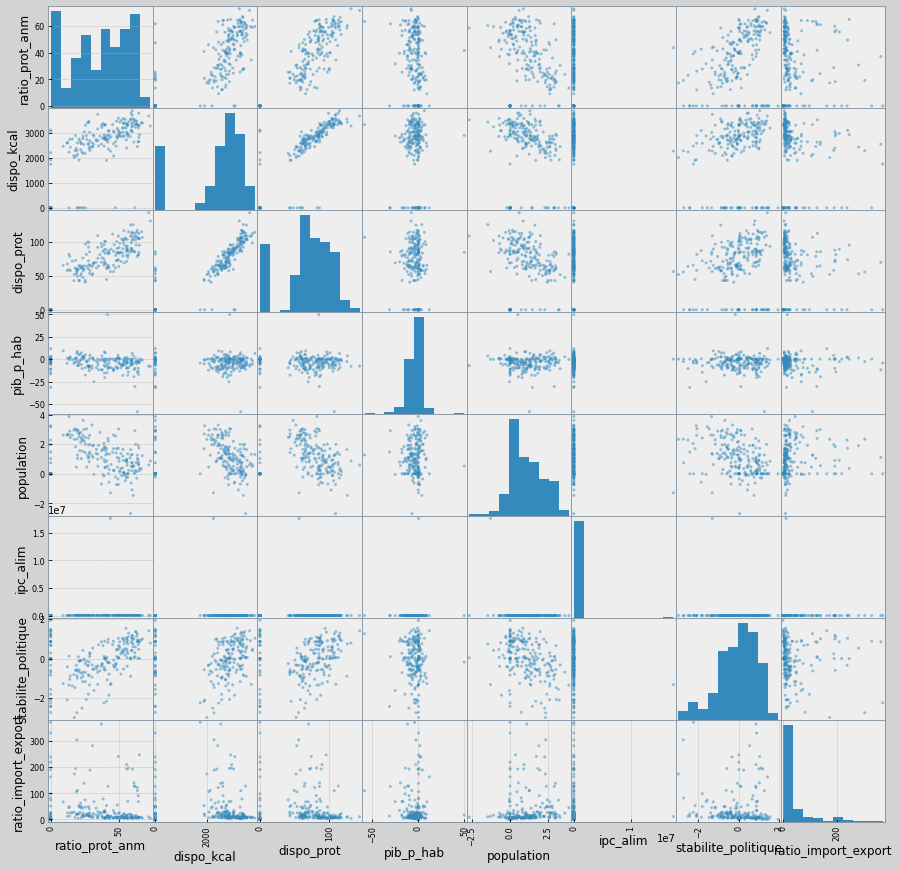

In [46]:
# mini-diagramme de corrélation entre variables
pd.plotting.scatter_matrix(market, figsize = (15,15))


Le ratio de protéine animale est très fortement corrélée avec les disponibilités calorique et protéinique.  
Etrangement, la population et le pib par habitant présente une corrélation linéaire avec quasiment toutes les variables exceptées l'ipc. Tous ces groupes de variables nous informent que des informations pèseront plusieurs fois dans calculs. Regardons comment se comportent les individus.
Les minis-diagrammes sont bien jolis mais choisissons une représentation sous forme de heatmap pour plus de clareté.

<AxesSubplot:xlabel='produit', ylabel='produit'>

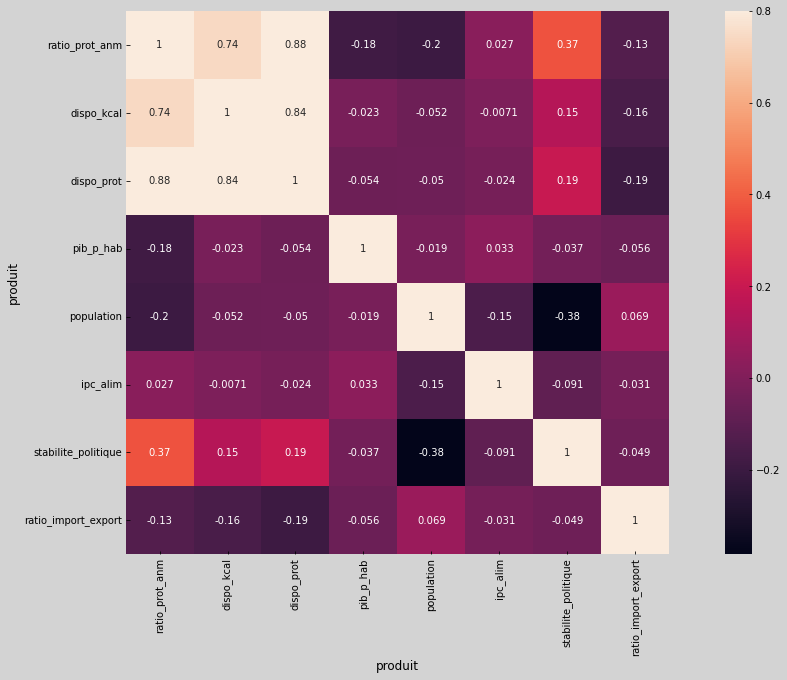

In [47]:
# heatmap de corrélations de Market
mat_corr = market.corr()
f, ax = plt.subplots(figsize = (20, 10))
sb.heatmap(mat_corr, vmax = .8, square = True, annot = True) #, mask = np.triu(market.corr()))

Plus la couleur est claire, plus forte le chi2 s'approche de 1 et plus importante est le degré de corrélation entre deux variables. Sans réelle surprise, nous constatons d'emblée une très forte corrélation entre les disponibilités alimentaires en protéine, calorie et le ration de protéine d'origine animale. une autre façon de caractéériser ces trois corrélations est de dire que toutes les observations/calculs incluant ces trois variables compteraient pour triple. Donc nous pourrions mettre de côté deux d'entre elles et n'en utiiser qu'une seule pour les études à venir.

In [48]:
# construction de la fonction dendrogramme
def plot_dendrogram(z, name) :
    plt.figure(figsize = (15, 30))
    plt.title('\nHierarchical Clustering Dendrogram\n\n')
    plt.xlabel('\nDistance\n\n')
    plt.ylabel('\nCode zone\n\n')
    dendrogram(
        z,
        labels = name,
        orientation = 'left'
    )
plt.show()

In [49]:
# préparation des données pour le clustering de Market
x = market.values
pays = market.index

In [50]:
# centrage et réduction
std_scale = preprocessing.StandardScaler().fit(x)
x_scaled = std_scale.transform(x)

In [51]:
# clustering hiérarchique
z = linkage(x_scaled, 'ward')

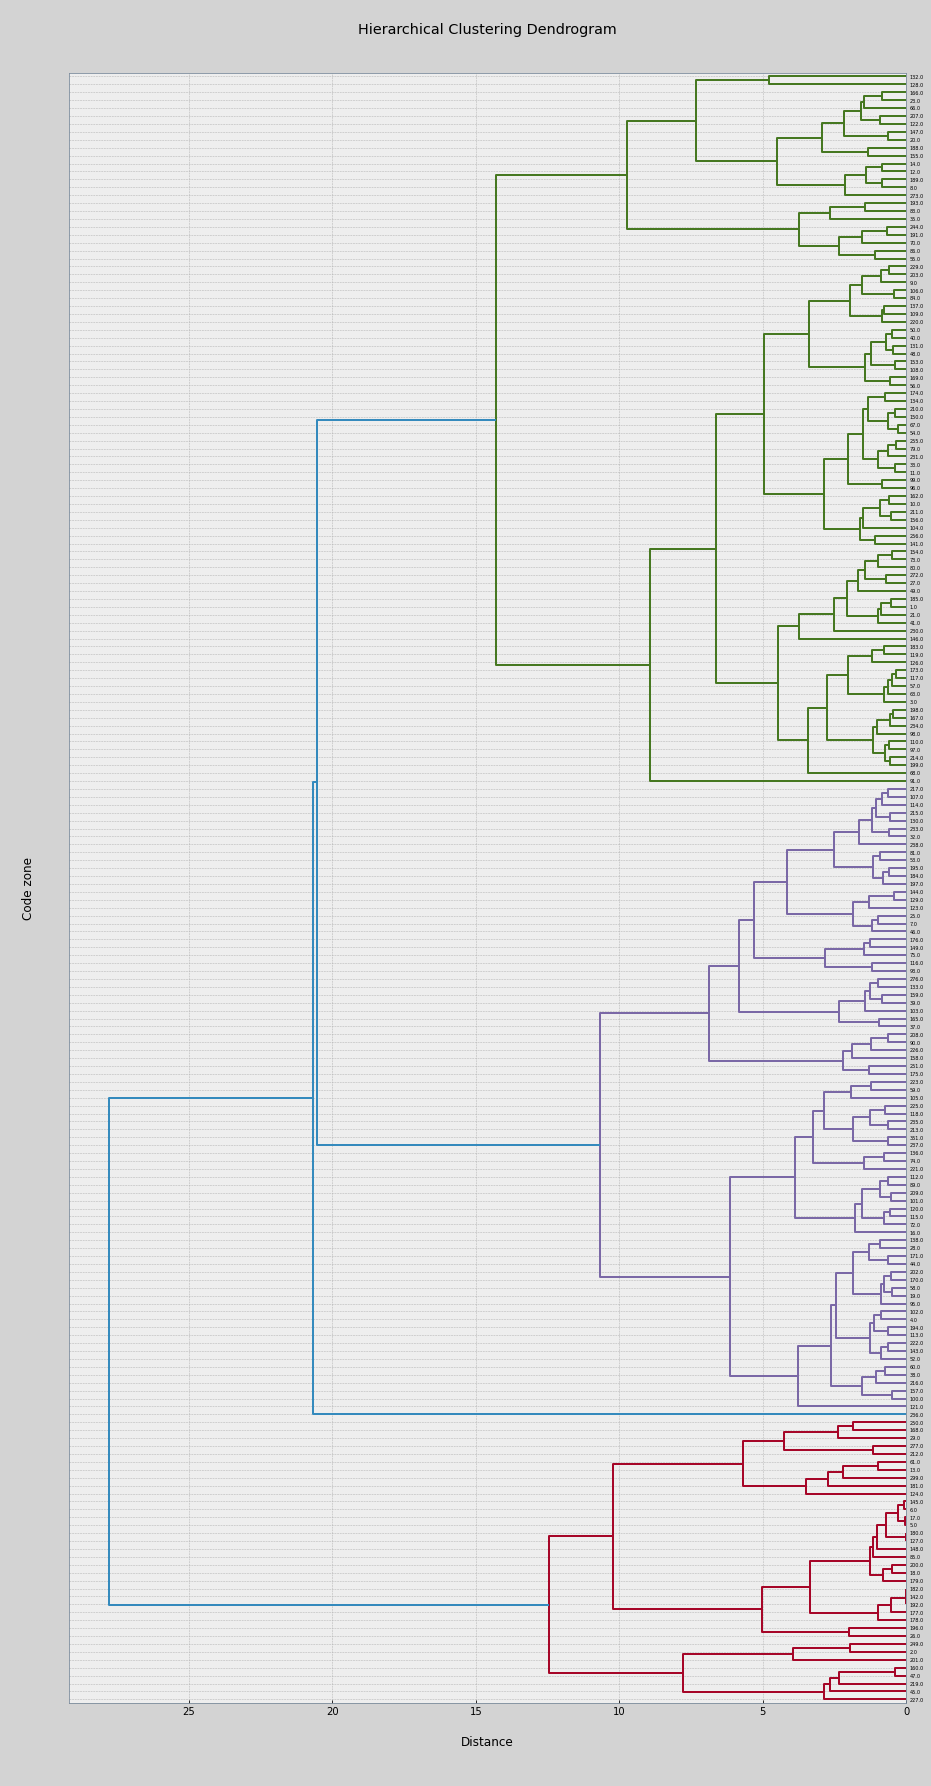

In [52]:
# affichage du dendrogramme
plot_dendrogram(z, pays)
plt.savefig('dendrogramme_originel', dpi = 500)

Première observation : nous avons un groupe de pays (tout à gauche) qui se distingue complètement du reste de la planète. Le découpage idéal d'un dendrogramme se définit, visuellement par le nombres des plus grandes lignes verticales continues. Ici, elles sont au nombre de 6. Nous commençons par suivre les impératifs du problèmes, à savoir procéder à un découpage en 5 groupes mais nous allons peut-être devoir augmenter se nombre afin d'obtenir une liste restreinte de pays comme conseillé.

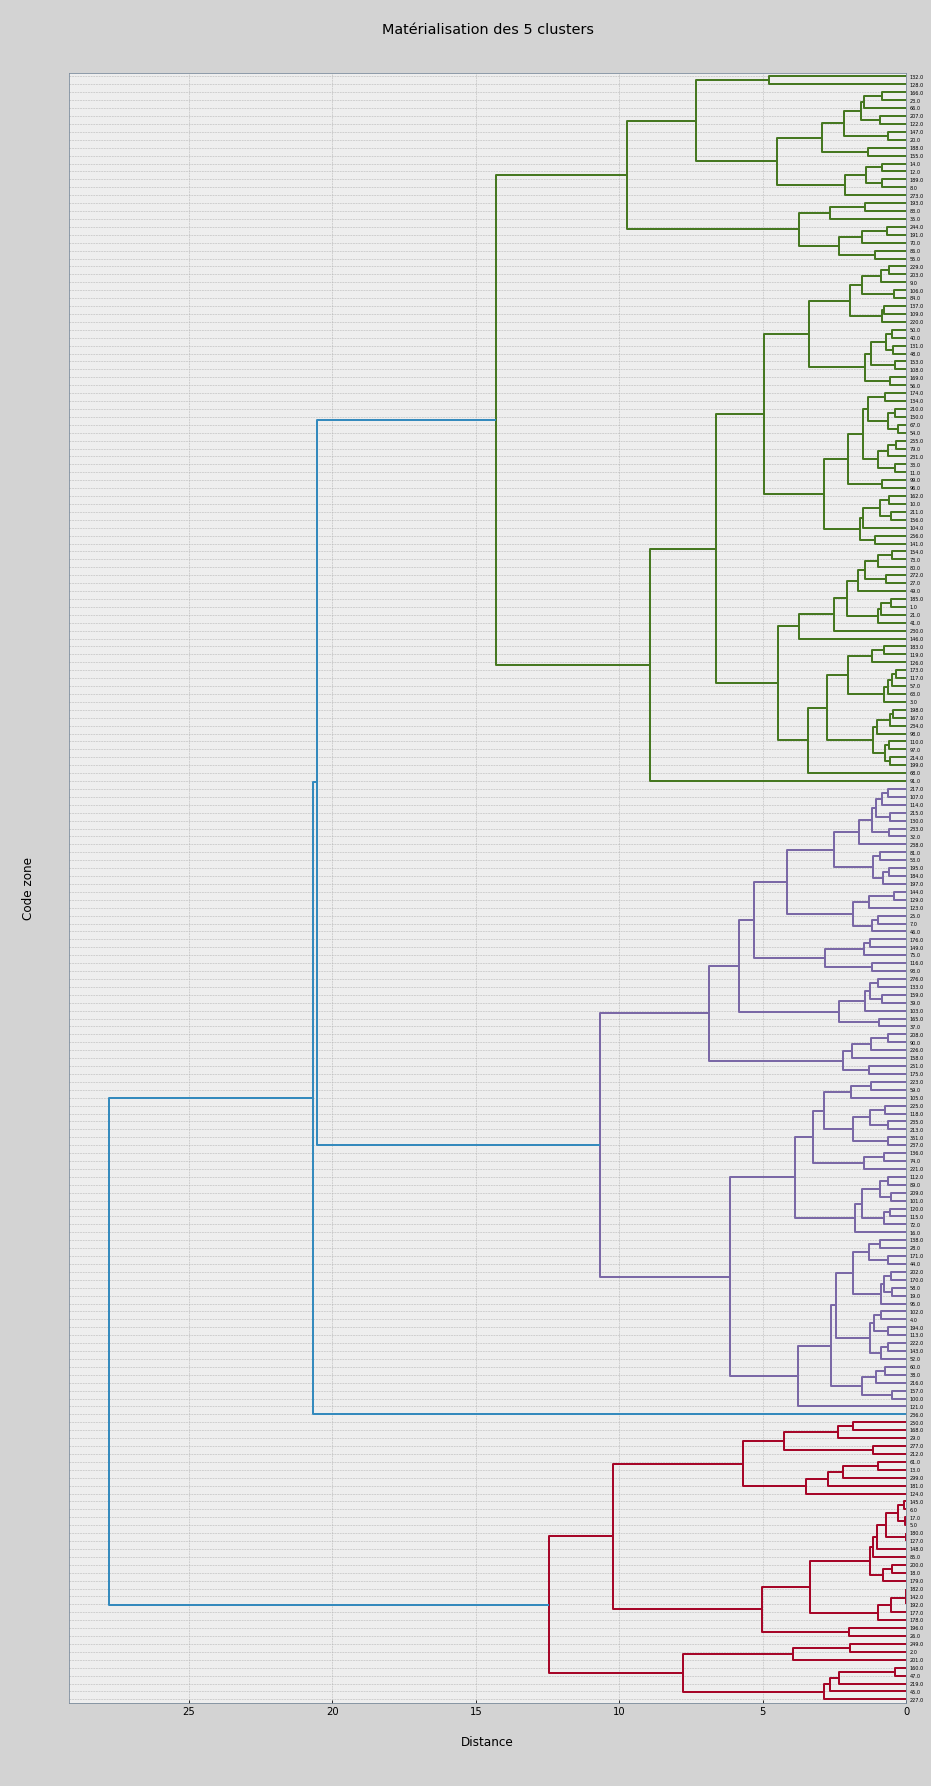

In [53]:
plt.figure(figsize = (15, 30))
plt.title('\nMatérialisation des 5 clusters\n\n')
plt.xlabel('\nDistance\n\n')
plt.ylabel('\nCode zone\n\n')
dendrogram(
    z,
    labels = pays,
    color_threshold = 15,
    orientation = 'left'
)
plt.show()    

Nos 5 groupes sont très disproportionnés. Le groupe 'rouge' réunit uniquement deux pays tandis que les 'violets' et 'gris regroupent plus des 3/4 des pays or nous voulons une liste restreinte d'individus => nous procédons dés maintenant à un découpage en 6 groupes.

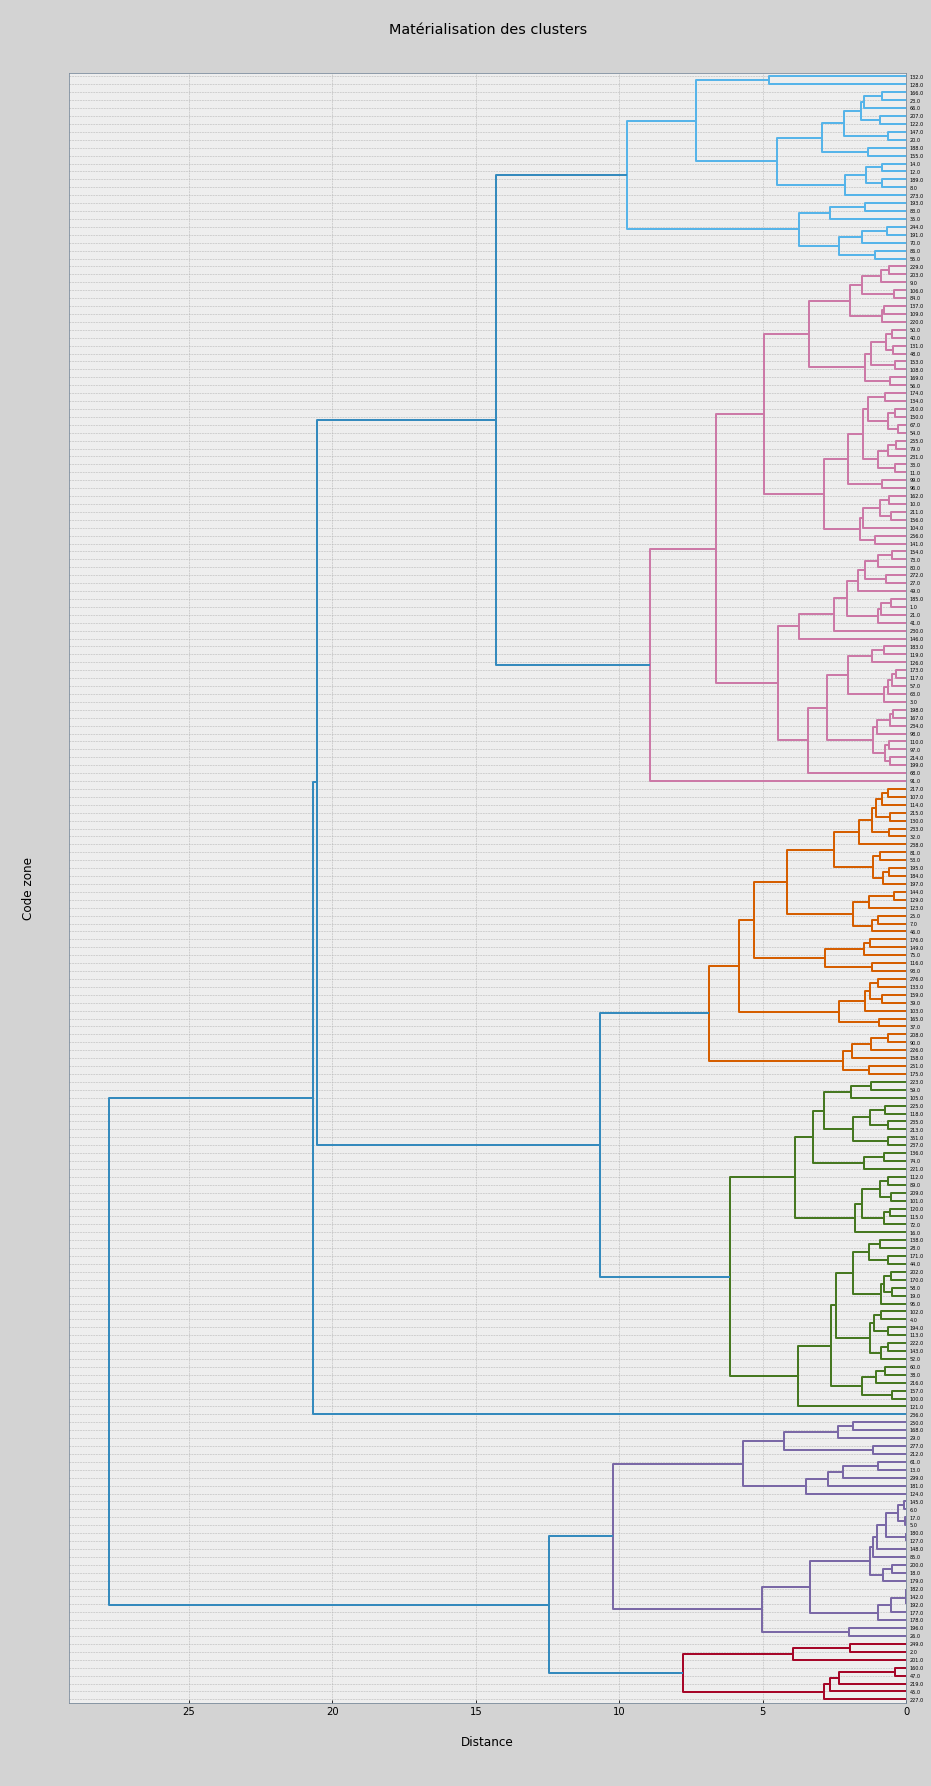

In [54]:
# création du dendrogramme en 6 groupes
plt.figure(figsize = (15, 30))
plt.title('\nMatérialisation des clusters\n\n')
plt.xlabel('\nDistance\n\n')
plt.ylabel('\nCode zone\n\n')
dendrogram(
    z,
    labels = pays,
    color_threshold = 10.5,
    orientation = 'left'
)
plt.show()    

In [55]:
# enregistrement des clusters selon le découpage en 6 groupes
cluster_6 = fcluster(z, 6, criterion = 'maxclust')

In [56]:
# trie des index selon les appartenances aux clusters
cluster_idx = np.argsort(cluster_6)

In [57]:
# création d'un df dictionnaire des code_zones et leur numéro de clusters
groupage_6 = pd.DataFrame(market.index[cluster_idx], cluster_6[cluster_idx])

In [58]:
# colonne renommée et utilisation des index clusters comme variables
cluster_6 = groupage_6.reset_index()
cluster_6.rename(columns = {'index':'cluster'}, inplace = True)

In [59]:
# injection des clusters dans le df principal Market
market = market.join(cluster_6.set_index('code_zone'))

Ce qui frappe en premier lieu sont les clusters 4 et 5 qui sont, en réalité, chacun composés d'un seul et unique pays. Utilisons le Dico_zone pour connaître leur identité usuelle et réitérons le clustering des pays sans ces deux-là.

In [60]:
dico_zone[(dico_zone.code_zone == 128) | (dico_zone.code_zone == 236)]

,pays,code_zone
143,Chine - RAS de Macao,128
636,Venezuela (R?publique bolivarienne du),236


In [61]:
# création d'un Market alternatif sans les outliers dit restreint
# le code_zone 277 apparaît, par la suite, comme étant un outlier
market_r = market.drop(index = [128, 236, 277])

In [62]:
# suppression de la colonne "cluster" issue du 1er clustering
market_r.drop('cluster', axis = 1, inplace = True)

In [63]:
# repréparation des données pour le dendrogramme avec la nouvelle bdd (sans outliers)
x_r = market_r.values
pays_r = market_r.index

std_scaled_r = preprocessing.StandardScaler().fit(x_r)
x_scaled_r = std_scaled_r.transform(x_r)

z_r = linkage(x_scaled_r, 'ward')

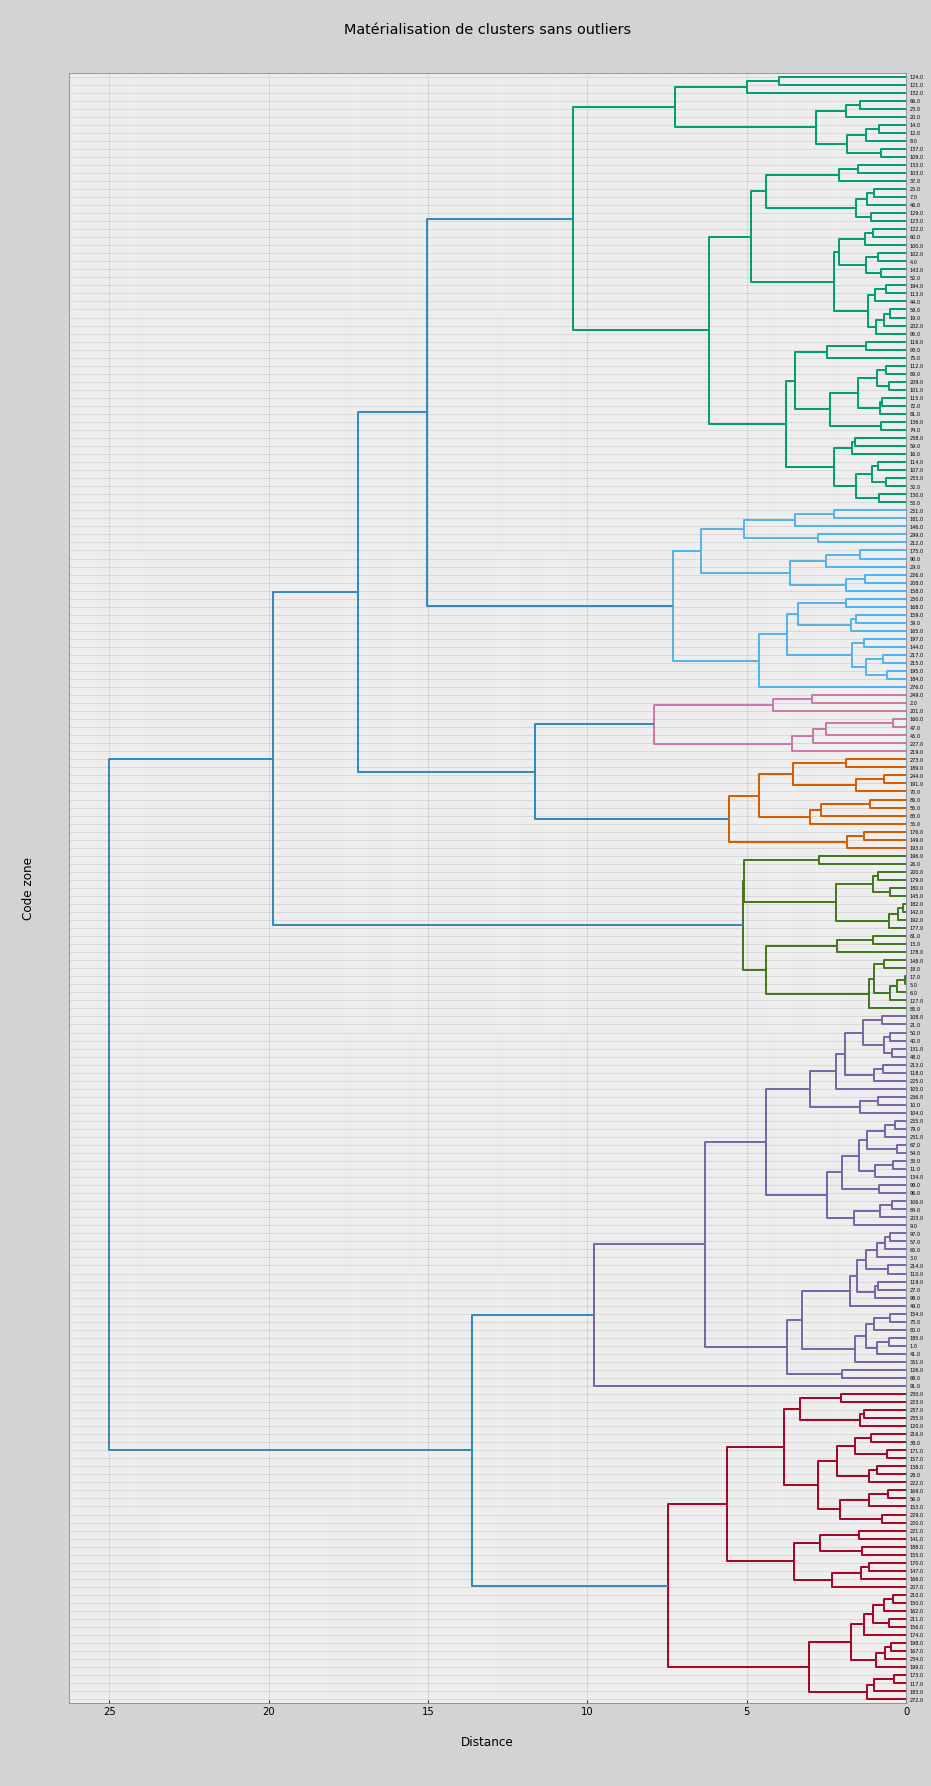

In [64]:
plt.figure(figsize = (15, 30))
plt.title('\nMatérialisation de clusters sans outliers\n\n')
plt.xlabel('\nDistance\n\n')
plt.ylabel('\nCode zone\n\n')
dendrogram(
    z_r,
    labels = pays_r,
    color_threshold = 11,
    orientation = 'left'
)
plt.savefig('dendrogramme_7_clusters', dpi = 500)
plt.show()

Nous reparcourons le processus d'intégration des clusters au df Market_r.

In [65]:
# enregistrement des clusters selon le découpage
cluster_cah = fcluster(z_r, 7, criterion = 'maxclust')

In [66]:
# tri selon appartenances aux clusters
cluster_idx_r = np.argsort(cluster_cah)

In [67]:
# création du df dictionnaire code_zone-clusters
groupage_r = pd.DataFrame(market_r.index[cluster_idx_r], cluster_cah[cluster_idx_r])

In [68]:
# renommage de colonne et utilisation des index clusters comme variables
cluster_r = groupage_r.reset_index()
cluster_r.rename(columns = {'index':'cluster_cah'}, inplace = True)

In [69]:
# injection des clusters dans le df Market_r
market_r = market_r.join(cluster_r.set_index('code_zone'))

In [70]:
# aperçu des effectifs des clusters pour vérifier les outliers, aka cluster mono-pays
market_r.cluster_cah.value_counts()

7    54
2    47
1    39
6    23
3    20
4    12
5     8
Name: cluster_cah, dtype: int64

**2.2 Caractéristiques des clusters**  
  
Nous voulons avoir un aperçu du comportement des clusters selon nos variables. Pour avoir une vue d'ensemble, nous procédons à une représentation sous forme de boxplot trié par variable.

In [71]:
# préparation des données : suppression de la variable 'cluster' inutile ici
market_rest = market_r.drop('cluster_cah', axis = 1)

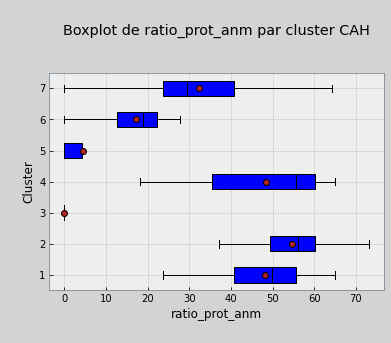

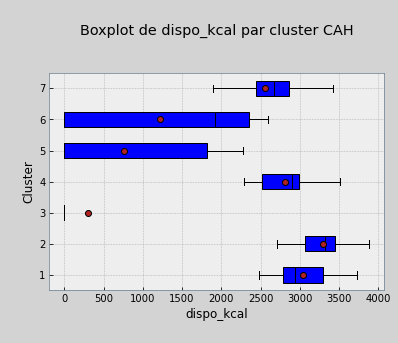

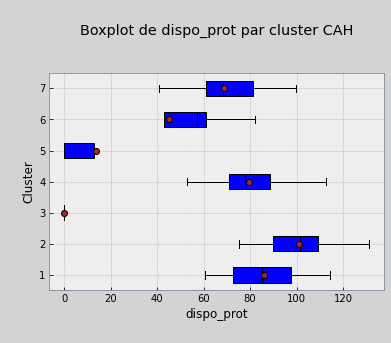

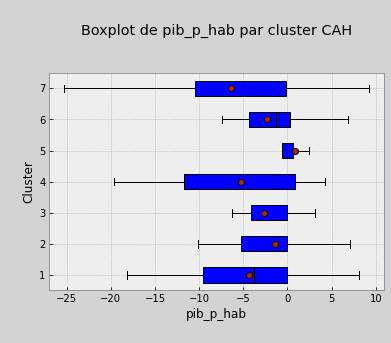

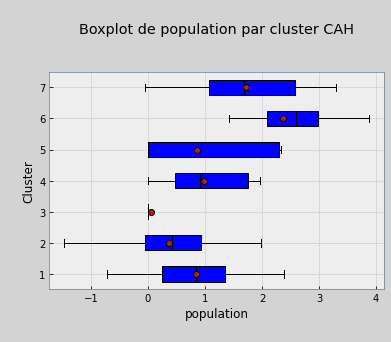

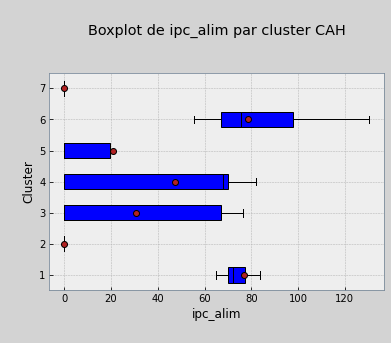

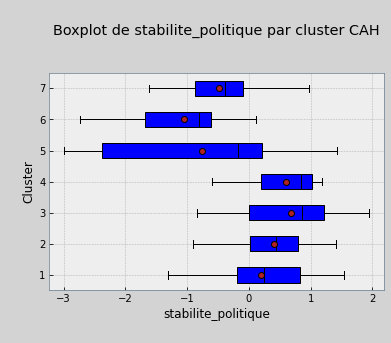

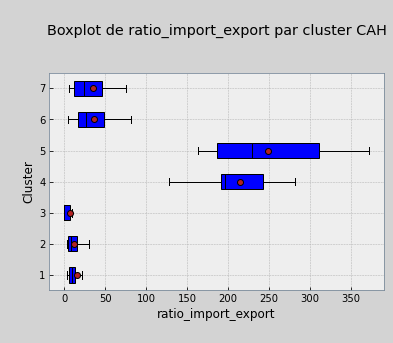

In [72]:
# boxplot des variables par clusters avec les données restreintes
for variable in market_rest.columns :
    X = 'cluster_cah'
    Y = variable

    modalite = market_r[X].sort_values().unique()
    groupe = []

    for m in modalite:
        groupe.append(market_r[market_r[X] == m][Y])

    medianprops = {'color':"black"}
    meanprops = {
            'marker':'o',
            'markeredgecolor':'black',
            'markerfacecolor':'firebrick'
            }
    
    plt.boxplot(
        groupe,
        labels = modalite,
        showfliers = False,
        medianprops = medianprops,
        vert = False,
        patch_artist = True,
        showmeans = True,
        meanprops = meanprops
        )
    plt.title(f"\nBoxplot de {variable} par cluster CAH\n\n")
    plt.xlabel(f'{variable}\n')
    plt.ylabel('\nCluster')
    plt.savefig('boxplot_variable_cluster_cah', dpi = 500)
    plt.show()

o Ratio import/export  
Il y a 3 tendances.  
- La première concerne les clusters 1, 2 et 3. Leur ratio d'import/export n'a que très peu évolué en deux ans;  
- La deuxième tendance peu être vu come un cas particulier de la première. Leur ratio a certes évolué mais la différence entre leur moyenne et leur médiane laisse penser à une évolution très hétérogènes entre les pays des clusters 6 et 7;  
- La troisième tendance est la plus intéressante puisque le ratio des importations face exportations à exploser. Comme pour la 2e tendance, la différence entre la moyenne et la médiane et l'entendue de la distribution annoncent une grande hétérogénéité dans la croissance du ratio entre les pays des groupes 4 et 5.  
  
o IPC alimentaire  
- Les clusters 2 et 7 n'ont pas connu d'inflation entre 2018 et 2020 donc le différentiel de leur ipc restent proche de 0;  
- Les pays des clusers 1 et 6 ont fait face à une augmentation élevée des prix de l'alimentation de même que le cluster 4 dont une faible portion de ses pays ayant pu maintenir un ipc proche de 0;  
- Les groupes 3 et 5 ont majoritairement des pays ayant eu une inflation faible voire nulle.  
  
o Population  
- Les pays du cluster 3 n'a pas connu d'accroissement démographique entre 2018 et 2020;  
- 1 et 2 ont près de la moitié de leurs pays respectifs ayant eu une démographie;  
- Tous les autres clusters ont eu une augmentation de leur Population.  
  
o PIB/habitant  
- Seul le cluster 5 a réussi à maintenir son PIB stable entre les deux années car distribution concentrée et au voisinage de 0;  
- Sinon, le différentiel étant négatif, le PIB de 2020 est donc inférieur à celui de 2018 et tous les clusters ont majoritairement eu une baisse de leur pib allant de pair avec la situation sanitaire mondiale et ses conséquences économiques néamoins quelques pays ont réussi à avoir un taux d'accroissement du PIB positif, cette caractéristique est particulièrement vrai pour la moitité des pays du cluster 3.  
  
o Disponibilité en protéine/ Disponibilité calorique  
- Comme attendu, le cluster 3 n'ayant pas subi d'augmentation démographique, ses besoins en protéines et calories n'ont pas évolué en deux ans.
- Le cluster 5 réunit des pays ayant eu un important accroissement démographique positif mais uniquement pour la moitité de ses pays pourtant nous observons une très faible évolution des disponibilités en protéines mais une explosion des disponibilités caloriques, ce cluster doit certainement avoir des habitudes alimentaires majoritairement basés sur des glucides (grandes sources de calories) tels que des céréales;  
- Le cluster 6 est également un cas particulier car l'évolution de ses disponibilités caloriques est très étendu (de 0 à plus de 2500 kcal) mais la moyenne étant inférieure à la médiane (trait d'un kurtosis négatif) donc plus de la moitié des ses pays ont vu une fort taux d'accroissement de leur disponibilités caloriques et protéiniques et donc un important développement des marchés respectifs;  
- Pour tous les autres groupes, les disponibilités en proteines et caloriques ont augmenté laissant penser que les marchés se sont développés et ont répondu à la demande croissante de la population. Nous avons donc un risque de saturation des marchés dans les pays de ces clusters.  
  
o Ratio de protéines animales  
- Les clusters 3 reste toujours cantonné à une évolution nulle de même que le cluster 5 n'a pas connu d'évolution significative;  
- 1, 2, 4, 6 et 7 sont les clusters ayant eu les plus importantes augmentations de leur disponibilités en protéines or l'évolution du ratio de protéine animal du cluster 6 est le plus modéré ainsi que pour la moitié des pays du groupe 7. Au final, seuls les clusters 1, 2 et 4 concentrent les meilleurs taux d'accroissement positif de leur consommation de viande.

A présent :  
- nous récupérons les valeurs absolues des clusters contenues dans le df Market_20;  
- nous utilisons le df Market qui contient les clusters des pays et concatons les deux;  
- nous regardons comment se comportent leurs données en continuant d'utiliser la représentation en boxplot.

In [73]:
# concaténation du df de données de 2020 et du df clusterisé indéxés par code_zone
market_abs = pd.concat([market_20, market_r.cluster_cah], axis = 1)

In [74]:
# pays ayant été retiré lors du clustering => NaN dans "cluster" => à retirer
market_abs.dropna(inplace = True)

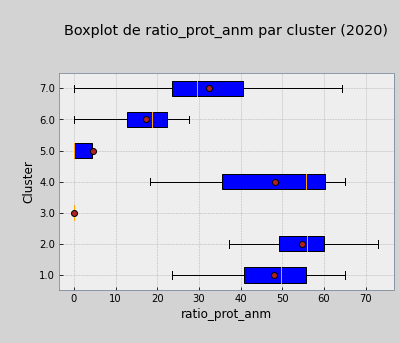

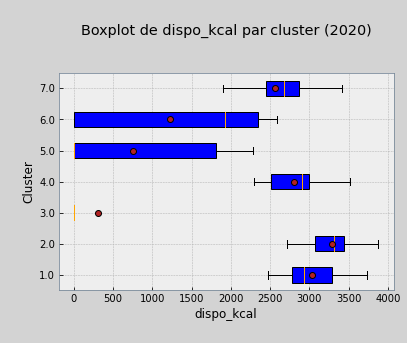

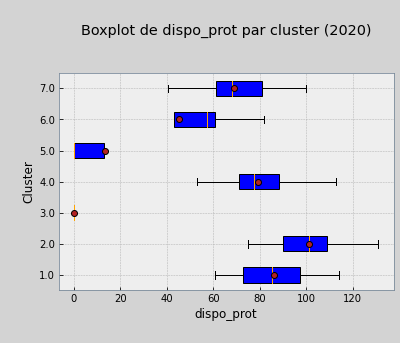

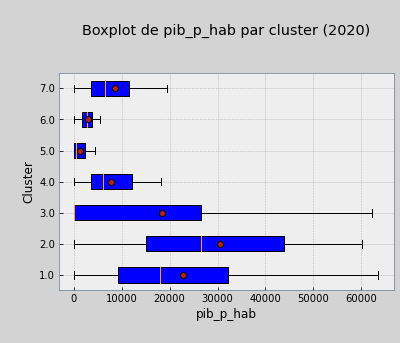

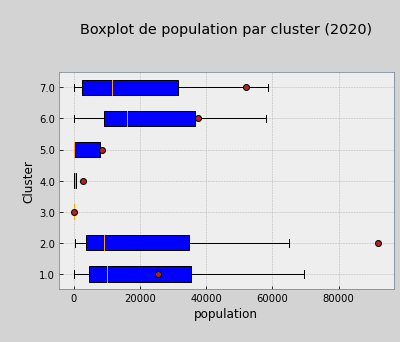

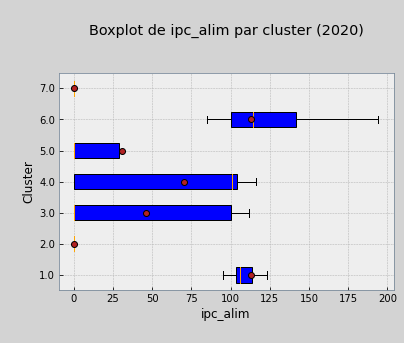

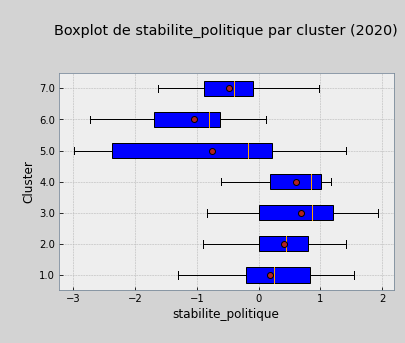

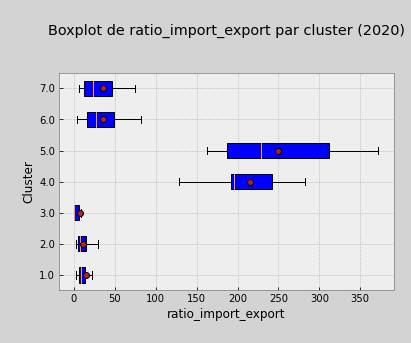

In [75]:
# boxplot des variables par clusters de Market_20
for variable in market_20.columns : # nous évite d'avoir la colonne "cluster" représentée
    X = 'cluster_cah'
    Y = variable

    modalite = market_abs[X].sort_values().unique()
    groupe = []

    for m in modalite:
        groupe.append(market_abs[market_abs[X] == m][Y])

    medianprops = {'color':"orange"}
    meanprops = {
            'marker':'o',
            'markeredgecolor':'black',
            'markerfacecolor':'firebrick'
            }
    
    plt.boxplot(
        groupe,
        labels = modalite,
        showfliers = False,
        medianprops = medianprops,
        vert = False,
        patch_artist = True,
        showmeans = True,
        meanprops = meanprops
        )
    plt.title("\nBoxplot de {} par cluster (2020)\n\n".format(variable))
    plt.xlabel('{}\n'.format(variable))
    plt.ylabel('\nCluster')
    plt.savefig('boxplot_variable_2020_cluster_cah', dpi = 500)
    plt.show()

o Cluster 1 :  
- disponibilités en calorie et en protéine très importants;  
- consommation de protéine animale très élevée et supérieure aux besoins nutritifs;  
- pib par habitant très étendu et mais reste parmis les plus importants pour 75% de ses pays;  
- IPC alimentaire, très concentré est l'un des plus importants des 7;  
- la stabilité politique et social reste bonne bien que quelques pays aient connu quelques instabilités;  
- le ratio import/export est extrêmement basse;  
=> la production est largement suffisante pourvoir aux besoins excédentaires de la population et sujette à d'importantes exportations. Ce cluster possède des pays riches, développés mais sont autosuffisants dans leur besoins alimentaires, marché peut-être saturé.

o Cluster 2 :  
- profil nutritif identique au cluster 1 : surconsommation calorique et protéinique, même d'origine animale;  
- distribution du PIB/hab. très étendue. Reste élevé un des plus élevés pour la majorité de ses pays;  
- population par pays très hétérogènemais reste basse pour la moitié d'entre eux. Une moyenne en dehors des whiskies suggère la présence de quelques foyers principaux de population;  
- IPC alimentaire ponctuel et au voisinage de 0 => tous les pays de ce clusters accorde très peu de dépenses dans l'alimentaire malgré un PIB/hab important;  
- stabilité politique positive, quelques cas éparses exceptés;  
- pays exportant plus qu'il n'importent;  
=> cluster dont les pays sont autosuffisants, le faible IPC suggère des pays ayant une économie autarcique ne reposant pas sur l'agriculture.  
  
o Cluster 3 :  
- disponibilités nutritives quasi-inéxistants [? : pb don];  
- PIB/hab concentré dans les faibles valeurs et très hétérogène, au voisinage de 0 pour plus de la moitié des pays;  
- population extrèmement basse ;  
- part de dépenses dans l'alimentaire ayant une distribution très étendue dont, pour la moitié des pays, est presque nul. Profil très hétérogène;  
- pas d'instabilité politique notable;  
- très faible ratio import/export;  
=> cluster économiquement faible, marché agricole ne répondant pas aux besoins d'une population très basse. Principalement des îles?  
  
o Cluster 4 :  
- Profil identique au cluster 1 (surconsommation) avec un spectre du ratio de protéines animales deux fois plus étendu que les deux premiers;  
- PIB/hab. bien inférieur à 1 et 2 : concentré et bas;  
- densité de population très basse;  
- dépenses alimentaires très élevée;  
- pas d'instabilité politique;  
- 2e plus grand importateur;  
=> production agricole intérieure insuffisante pour couvrir la demande, économie ouverte => critères adéquats pour un nouveau marché à taille moyenne.  
  
o Cluster 5 :  
- disponibilités nutritionnelles basses pour les protéines et les calories bien que cette dernière soit très étendue, la valeur de la moyenne par rapport à la médiane tend à montrer une agglomération des pays dans les valeurs inférieures;  
- distribution concentrée => tous les pays de ce cluster ont un PIB/hab extrèmement bas le plus faible de tous les groupes);  
- pays peu peuplés;  
- une des IPC les plus faibles;  
- forte instabilité politique pour plus de la moitité de ce cluster;  
- plus grand importateur des 7;  
=> ce cluster est très dépendant des marchés étrangers pour sustenter les besoins alimentaires de sa population mais les caractéristiques économiques et politiques en fond un marché instable.
  
o Cluster 6 :
- disponiblités en protéine répondant aux besoins nutritionnels, proportion animale faible alors que la disponiblité calorique très étendue est dans les norme des besoins nutritionels. La position de la moyene par rapport à la médiane suggère une concentration des pays dans les valeurs supérieures => régime alimentaire reposant princiapelemnt sur les glucides;  
- PIB/hab. de 6 = un des plus bas por l'ensemble de ses pays;  
- densité de population importante;  
- IPC alimentaire le plus élevée des 7 clusters;
- instabilité politique quasiment pour tou les pays du cluster;  
- importation relativement faible;  
=> les besoins en protéines de la population ne sont pas couverts et son alimentation dépend surout de céréales issus de la production intérieure, un IPC très élevé donc dépenses alimentaires très importantes mais moyens financiers très limités. Afrique? Il pourrait y avoir un marché restreint à exploiter en visant les catégories sociaux-pro les plus aisées.  
  
o Cluster 7 :  
- disponibilités nutritionnelles suffisantes pour une consommation animale hétérogène (distribution très étendue);  
- PIB/hab. bas;  
- population principalement dans les valeurs inférieures;  
- IPC quasi-nul;  
- environnement politique négatif;  
- faible taux d'importation;  
=> ce cluster dépend principalement de sa production agricole, les dépenses alimentaires et l'environnement économique ne sont pas propices à l'ouverture d'un marché étranger.

**2.3 K-means et centroïdes**  
  
Déroulement en 7 étapes :  
o définition de trois fonctions du cours permettant d'obtenir :  
    - un éboulis des valeurs propres;  
    - une projection sur le premier plan factoriel avec les % d'inertie;  
    - un cercle des corrélations;  
o prépartion des données pour ACP;  
o éboulis des valeurs propres afin de qualifier les représentations;  
o projection des individus clusterisés avec K-means dans le premier plan factoriel;  
o calcul et représentation des centroïdes dans le premier plan factoriel sans et avec tous les individus clusterisés;  
o projection des variables du df réduit Market_r dans le cercle des corrélations;  
o conclusions et finitions de l'ACP.


o Déroulement 1/7 : définition de trois fonctions du cours permettant d'obtenir :  
    - un éboulis des valeurs propres;  
    - une projection sur le premier plan factoriel avec les % d'inertie;  
    - un cercle des corrélations

In [76]:
# fonction pour projection sur un plan factoriel avec % d'inertie
def display_factorial_plane(X_projected, n_comp, pca, axis_ranks, labels = None, alpha = 1, illustrative_var = None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure       
            fig = plt.figure(figsize = (7,6))

            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha = alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha = alpha, label = value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(x, y - .5, labels[i],
                              fontsize = '15', ha = 'center', va = 'center') 

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color = 'grey', ls = '--')
            plt.plot([0, 0], [-100, 100], color = 'grey', ls = '--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)\n'.format(d1+1, round(100 * pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('\nF{} ({}%)'.format(d2+1, round(100 * pca.explained_variance_ratio_[d2], 1)))

            plt.title("\nProjection (sur F{} et F{})\n\n".format(d1 + 1, d2 + 1))
            plt.show(block = False)

In [77]:
# fonction pour présenter le cercle des corrélations
def display_circles(pcs, n_comp, pca, axis_ranks, labels = None, label_rotation = 0, lims = None):
    for d1, d2 in axis_ranks: # on affiche les 3 premiers plans fatoriels => 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize = (7,6))

            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles = 'xy', scale_units = 'xy', scale = 1, color = "grey")
            else:
                lines = [[[0,0], [x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes = ax, alpha = .1, color = 'black'))

            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]]. T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize = '14', ha = 'center', va = 'center', rotation = label_rotation, color = "blue", alpha = 0.5)

            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor = 'none', edgecolor = 'b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color = 'grey', ls = '--')
            plt.plot([0, 0], [-1, 1], color = 'grey', ls = '--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)\n'.format(d1 + 1, round(100 * pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('\nF{} ({}%)'.format(d2 + 1, round(100 * pca.explained_variance_ratio_[d2], 1)))

            plt.title("\nCercle des corrélations (F{} et F{})\n\n".format(d1 + 1, d2 + 1))
            plt.show(block = False)

In [78]:
# fonction pour représenter l'éboulis des valeurs propres
def display_scree_plot(pca) :
    scree = pca.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(scree)) + 1, scree)
    plt.plot(
        np.arange(len(scree)) + 1,
        scree.cumsum(),
        c = "darkred",
        marker='o'
    )
    plt.xlabel("Rang de l'axe d'inertie\n")
    plt.ylabel("\n% d'inertie")
    plt.title("\nEboulis des valeurs propres\n\n")
    plt.show(block = False)

o Déroulement 2/7 : prépartion des données pour ACP  
  
- Une normalisation des données de Market_r a déjà été faite pour la création de son dendrogramme.  
  
- Théoriquement, nombre de composante = min(data.shape[0] + 1, data.shape[1].  
Mais des colonnes de calculs statistiques ayant été rajoutées par la suite, une restriction est faite sur les colonnes de Market_r afin d'utiliser uniquement les variables socio-économiques d'origine.  
=> dans le choix du nombre de composants qui se choisit par le minimum enntre la taille de la matrice des données, data.shape[1] devient :

In [79]:
# récupération du nom de variables socio-économiques
nom_variable = market_r.columns[:8]

In [80]:
# choix du nombre de composantes principales
n_comp_km = min(market_r.shape[0] + 1, len(nom_variable))

Bien que le dendrogramme suggérait 4 groupes et qu'il en était demandé 5, la création de 7 clusters nous est parue plus appropriée afin de pouvoir répondre à l'impératif de fournir une liste succinte de pays potentiels. Pour utiliser la méthode des k-means, nous devons fournir un nombre prédéfini de clusters et pour rester cohérent avec le travail déjà fait, nous choississons donc de créer 7 clusters.  
Nous utilisons ici, la bdd Market_r(rappel : df principal Market ôté des 3 outliers).

In [81]:
# clustering des données avec k-means
km = KMeans(n_clusters = 7)
km.fit(x_scaled_r)

c:\workplace\data_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=7)

In [82]:
# index de clusters pour chaque individu
cluster_km_r = km.labels_

In [83]:
# calcul des composantes principales
pca_r = decomposition.PCA(n_components = n_comp_km).fit(x_scaled_r)
x_projected_r = pca_r.transform(x_scaled_r)

o Déroulement 3/7 : éboulis des valeurs propres afin de qualifier les représentations

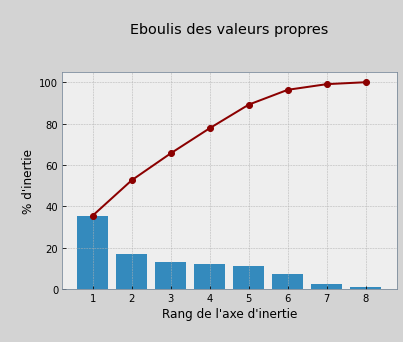

In [84]:
# représentation de l'éboulis des valeurs propres
display_scree_plot(pca_r)

Les deux premières composantes principales contribuent à près de 52% à l'inertie totale. Cette contribution n'est pas exemplaire mais au vue du nombre d'individus, nous la considérons suffisante et nous arrêtons au premier plan factoriel pour la représentation de nos données.  
Notons au passage une contribution (presque) équitablement répartie entre les variables 2 à 5 : l'effectif cumulé, très proche d'une fonction linéaire permet de conclure au choix pertinent des indices socio-économiques fait lors de l'acquisition des données.

o Déroulement 4/7 : projection des individus clusterisés avec K-means dans le premier plan factoriel

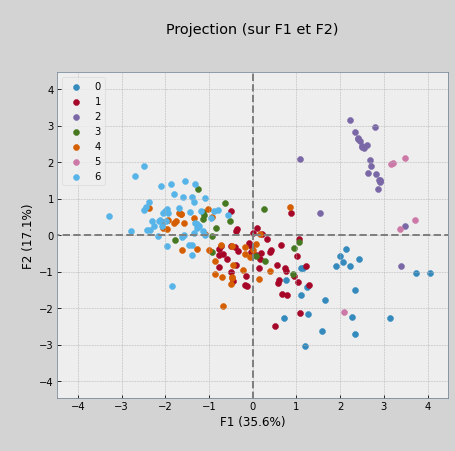

In [85]:
# projection des individus dans le 1er plan factoriel
display_factorial_plane(x_projected_r, 2, pca_r, [(0, 1)], None, 1, cluster_km_r)

La représentation du custering par les k-means est peu convaincante. Seul le cluster 'rouge' se démarque plus distinctement. Rappelons la contribution moyenne (dans le sens stricte du terme) de F1 et F2 pourrait expliquer cette disparité.  
Comparons ces clusters avec ceux obtenus par la méthode CAH.  
  
NB : le clustering à 5 groupes est légèrement plus net avec deux clusters plus distinctifs.

In [86]:
# tri des clusters k-meanniens
cluster_idx_km = np.argsort(cluster_km_r)

In [87]:
# création d'un df de correspondance code_zone/cluster_km
groupage_km_r = pd.DataFrame(market_r.index[cluster_idx_km], cluster_km_r[cluster_idx_km])

In [88]:
# renommage de colonne et utilisation des index clusters comme variables
cluster_km = groupage_r.reset_index()
cluster_km.rename(columns = {'index':'cluster_km'}, inplace = True)

In [89]:
# injection des clusters dans le df Market_r
market_r = market_r.join(cluster_km.set_index('code_zone'))

In [90]:
# correspondance avec le clustering CAH
pd.crosstab(market_r.cluster_cah, market_r.cluster_km )

cluster_km,1,2,3,4,5,6,7
cluster_cah,,,,,,,
1,39,0,0,0,0,0,0
2,0,47,0,0,0,0,0
3,0,0,20,0,0,0,0
4,0,0,0,12,0,0,0
5,0,0,0,0,8,0,0
6,0,0,0,0,0,23,0
7,0,0,0,0,0,0,54


Les groupes résultant des clusterings K-Means et CAH correspondent parfaitement : ce premier pas dans l'évaluation des différentiations des clusters est encourageant. Donc nous conservons les clusters k-meanniens en l'état et verrons à l'exécution des tests de comparaison et d'adéquation si les groupes diffèrent mathématiquement les uns des autres, ou pas.  
  
Nous exportons la liste des pays avec leur nom usuel.

In [91]:
# récupération des noms usuels des pays
bdd_cluster = market_r.join(dico_zone.set_index('code_zone'))

In [92]:
# ré-initialisation du df de clusters cah et km avec suppression des code_zones
bdd_cluster.reset_index(drop = True, inplace = True)

In [93]:
# exportation des données clusterisées par CAH et K-means
bdd_cluster[['pays', 'cluster_cah', 'cluster_km']].to_csv('clustering_cah_et_km.csv')

o Déroulement 5/7 : calcul et représentation des centroïdes dans le premier plan factoriel sans et avec tous les individus clusterisés

In [94]:
# calcul des centroïdes + préparation des données
centroids = km.cluster_centers_
centroids_projected = pca_r.transform(centroids)

In [95]:
# préparation des données : calcul des composantes pour les projections
pcs_r = pca_r.components_

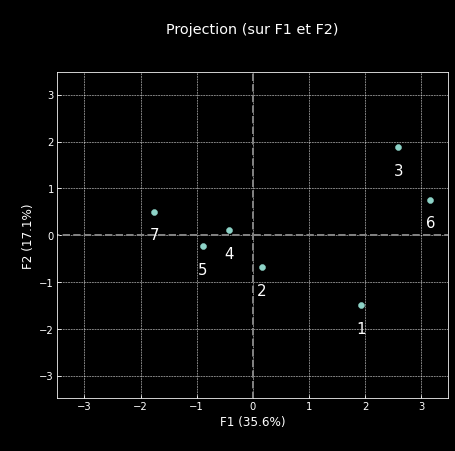

<Figure size 432x288 with 0 Axes>

In [96]:
# représentation des centroïdes sur le 1er plan factoriel
display_factorial_plane(centroids_projected, 2, pca_r, [(0, 1)], labels = market_r.index.astype(int), alpha = 1, illustrative_var = None)
plt.savefig('projection_centroides_f1_f2', dpi = 500)
plt.show()

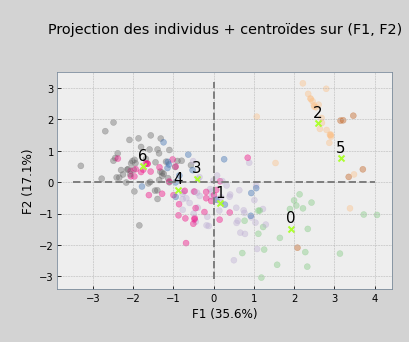

In [97]:
# projection individus + centroïdes dans (F1, F2)
plt.scatter(
    x_projected_r[:, 0],
    x_projected_r[:, 1],
    c = cluster_km_r.astype(float),
    cmap = 'Accent',
    alpha = .4
)
plt.scatter(
    centroids_projected[:, 0],
    centroids_projected[:, 1],
    c = 'greenyellow',
    marker = 'x'
)
for i, (x,y) in enumerate(centroids_projected[:, [0, 1]]) :
    plt.text(
        x, y + .35,
        i,
    fontsize = '15',
    ha = 'center',
    va = 'center'
    )
# affichage des lignes horizontales et verticales
plt.plot([-3.5, 4], [0, 0], color = 'grey', ls = '--')
plt.plot([0, 0], [-3.1, 3.2], color = 'grey', ls = '--')
plt.xlabel('F1 ({}%)\n'.format(round(100 * pca_r.explained_variance_ratio_[0], 1)))
plt.ylabel('\nF2 ({}%)'.format(round(100 * pca_r.explained_variance_ratio_[1], 1)))
plt.title("\nProjection des individus + centroïdes sur (F1, F2)\n\n")
plt.savefig('projection_centroide_individus_f1_f2', dpi = 500)
plt.show(block = False)

In [98]:
# conversion en dataframe = nommage des colonnes d'après les variables usuelles
bdd_centroide_var = pd.DataFrame(centroids, columns = bdd_cluster.columns[:8])

o Déroulement 6/7 : projection des variables du df réduit Market_r dans le cercle des corrélations

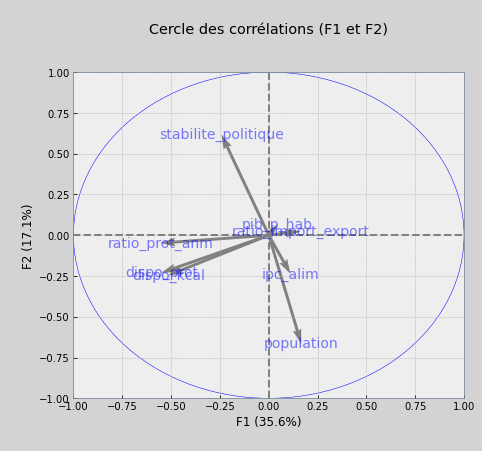

<Figure size 432x288 with 0 Axes>

In [99]:
# réprésentation des corrélations entre variables
display_circles(pcs_r, 2, pca_r, [(0, 1)], labels = market_r.columns[:8], label_rotation = 0, lims = None)
plt.savefig('cercle_correlation_f1_f2', dpi = 500)

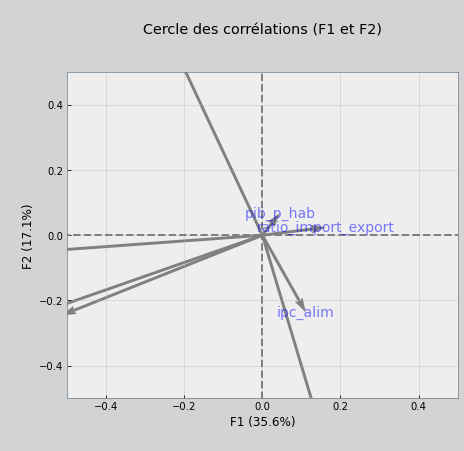

<Figure size 432x288 with 0 Axes>

In [100]:
# aggrandissement du centre du cercle
cercle_corr = display_circles(pcs_r, 2, pca_r, [(0, 1)], labels = market_r.columns[:8], label_rotation = 0, lims = (-.5, .5, -.5, .5))
plt.savefig('cercle_correlation_f1_f2_zoom', dpi = 500)

Observations du cercle :  
- contribution du plan factoriel = 52.7%;  
- comme pressenti en début de partie, les variables ratio_prot_anm et les diponibilités nutritives présentent le même comportement puisque corrélées : ici une corrélation négative avec F1 bien que leur projection sur le premier plan soient de moyenne qualité (longueur des flèche à mi-chemin du périmètre du cercle);  
- stabilité_politique et population sont les variables les mieux représentées sur ce plan, une forte affinité avec F2 dont les corrélations sont opposées;  
- pib_p_hab, ipc_alime et ratio_import_export sont les trois variables ayant la plus mauvaise représentation sur (F1, F2).

o Déroulement 7/7 : conclusions et finitions de l'ACP
  
=> (F1, F2)  
- les affinités des variables avec la deuxième composante principale nous indique de F2 regroupe grossièrement les aspects sociales des données, son expression à l'aide des variables initiales présentera des coefficients proches de +/-1;  
- F1 est l'aspect nutritionnel des données. A noter le 'est' en oppposition au 'regroupe' de F2 puisque le degré de corrélation de F1 avec ses variables est bien supérieur à celui de F2;  
- le reste des variables (quelque soit leur affinité) correspondent à l'aspect économique des données;  
  
=> les centroïdes  
- 1, 4, 6 et 7 sont très proches de F1;  
- 3 est proche à la fois de F1 et F2;  
- 2 est très éloigné à la fois de F1 et de F2;  
- et enfin le centroïde 5 reste proche du centre à equidistance de F1 et de F2;  
  
=> conclusions  
- tous les centroïdes (et par extension, les individus de leur cluster) prochent de F2 dépendent principalement des variables les plus corrélées à F2 à savoir les variables en mode "sociale";  
- ceux proche de 2 sont davantage dépendant de l'aspect nutritionnel;
- ceux qui ne sont proches ni de l'un ni de l'autre sont plus rattaché aux paramètres économiques;  
  
=> finitions de l'ACP : les étapes  
o nous exprimons les centroïdes en fonction de F1 et F2;  
o nous exprimons F1 et F2 en tant que combinaison linéaire des variables;  
o nous créons un df qui sera notre nouvelle bdd d'étude, il contiendra toutes les données sur les centroïdes et l'ACP;  
o nous exportons les données au format csv.


=> finitions de l'ACP : nous exprimons les centroïdes en fonction de F1 et F2

In [101]:
# expressions des centroïdes en fonction des composants principales
bdd_centroid_acp = pd.DataFrame(centroids_projected, columns = ["F" + str(i+1) for i in range(8)])

In [102]:
# expression des centroïdes en fonction des deux premières composantes principales
bdd_centroid_f1_f2 = bdd_centroid_acp[['F1', 'F2']]

In [103]:
# df général de centroïdes : variables + acp
bdd_centroide = bdd_centroid_f1_f2.join(bdd_centroide_var)

In [104]:
# réinitialisation de df
bdd_centroide.reset_index(inplace = True)
bdd_centroide.rename(columns = {'index' : 'centroide'}, inplace = True)

=> finitions de l'ACP : nous exprimons F1 et F2 en tant que combinaison linéaire des variables

In [105]:
# extraction des valeurs propres de F1
f1 = pca_r.components_[0]

In [106]:
# extraction des valeurs propres de F2
f2 = pca_r.components_[1]

In [107]:
# df des composantes principales en fonction des variables
bdd_acp_fi = pd.DataFrame(pca_r.components_, columns = nom_variable, index = ["f" + str(i + 1) for i in range(8)])

In [108]:
# composition des deux premières composantes principales
bdd_acp_fi.head(2)

,ratio_prot_anm,dispo_kcal,dispo_prot,pib_p_hab,population,ipc_alim,stabilite_politique,ratio_import_export
f1,-0.553674,-0.514119,-0.549693,0.045016,0.166212,0.111184,-0.242120,0.162255
f2,-0.048248,-0.245613,-0.229874,0.067690,-0.665010,-0.236506,0.617387,0.024127


- Pour rappel, F2 était la composante d'aspect "sociale" et F1, la "nutrionnelle. Nous retrouvons les coefficients de corrélation entre les variables et les premières composantes avec bien plus de précision.  
- Par exemple, F1, la variable synthétique "nutritionnelle" est exprimée avec les plus hauts coefficients pour tous ce qui concernent les variables initiales nutrtionnelles.  
- Pour F2, nous avons bien la variable initale ratio_im_export ayant le plus faible coefficient car projection presque orthogonale à F2 sur le cercle.

=> finitions de l'ACP : nous créons un df qui sera notre nouvelle bdd d'étude, il contiendra toutes les données sur les centroïdes et l'ACP

=> finitions de l'ACP : exportation

In [109]:
# exportation des centroids
bdd_centroide.to_csv('liste_centroide.csv')

Nous venons d'étudier l'évolution des aspects économiques et sociales des pays. A présent, ils nous faut confronter ces données avec l'état "actuel" des marché : les données les plus récentes étant de 2020.  
Rappelons que toutes les données de 2020 sont réunies sous le df Market_20. Chaque résultat des clculs découlant de Market sera marqué du suffixe "_20" (NomDeVariable_20).

In [110]:
# supression d'outlier faite ici pour être pris en compte dans normalisation des données
market_20.drop([236, 277], inplace = True)

Dans la préparation des données de Larket_20 qui suit, nous considérons les 8 premiers paramètres correspondant aux variables socio-éco. étudiées, la dernière colonne étant celle des clusters du CAH dont les valeurs ne doivent pas être prises en compte => restriction.

In [111]:
# préparation des données
x_20 = market_20.iloc[:, :8].values
pays_20 = market_20.index

In [112]:
# normalisation des données : ici obligatoire car différentes unités
std_scale_20 = preprocessing.StandardScaler().fit(x_20)
x_scaled_20 = std_scale_20.transform(x_20)

In [113]:
# clustering hiérarchique
z_20 = linkage(x_scaled_20, 'ward')

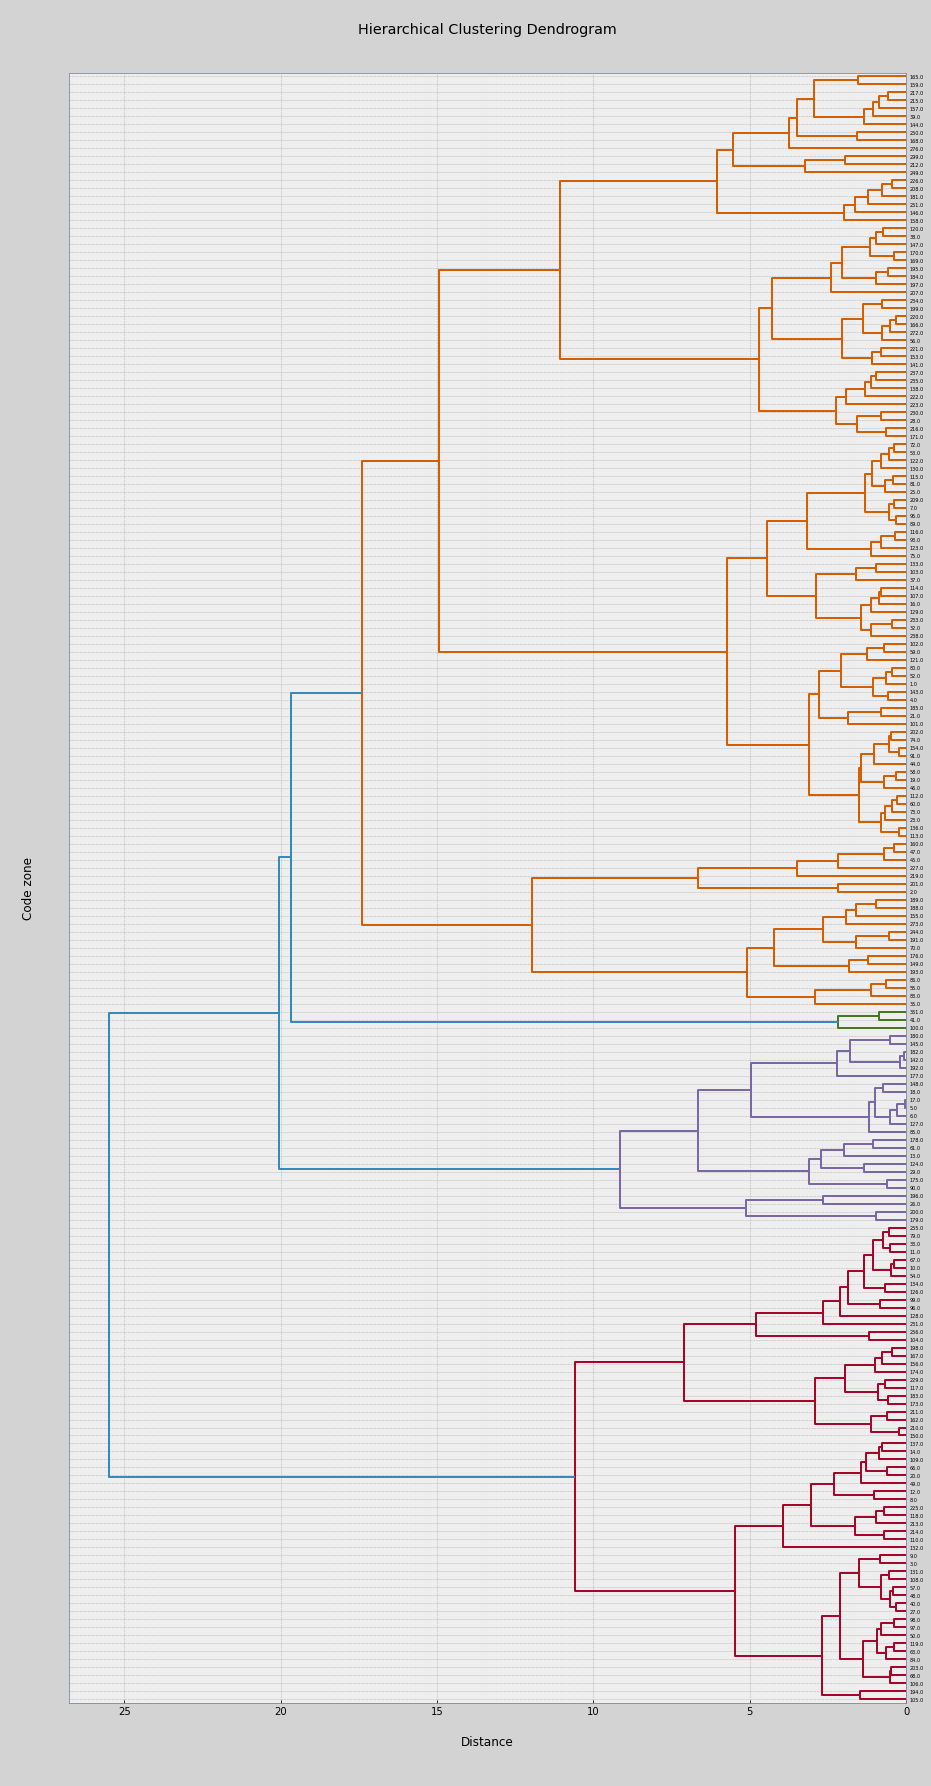

In [114]:
# affichage du dendrogramme
plot_dendrogram(z_20, pays_20)
plt.savefig('dendrogramme_2020', dpi = 500)

5 groupes sont suggérés par le dendrogramme. Notons également la présence d'un outlier que nous supprimons et d'un cluster très restreint composé de 3 pays que nous choississons pour l'instant de conserver.

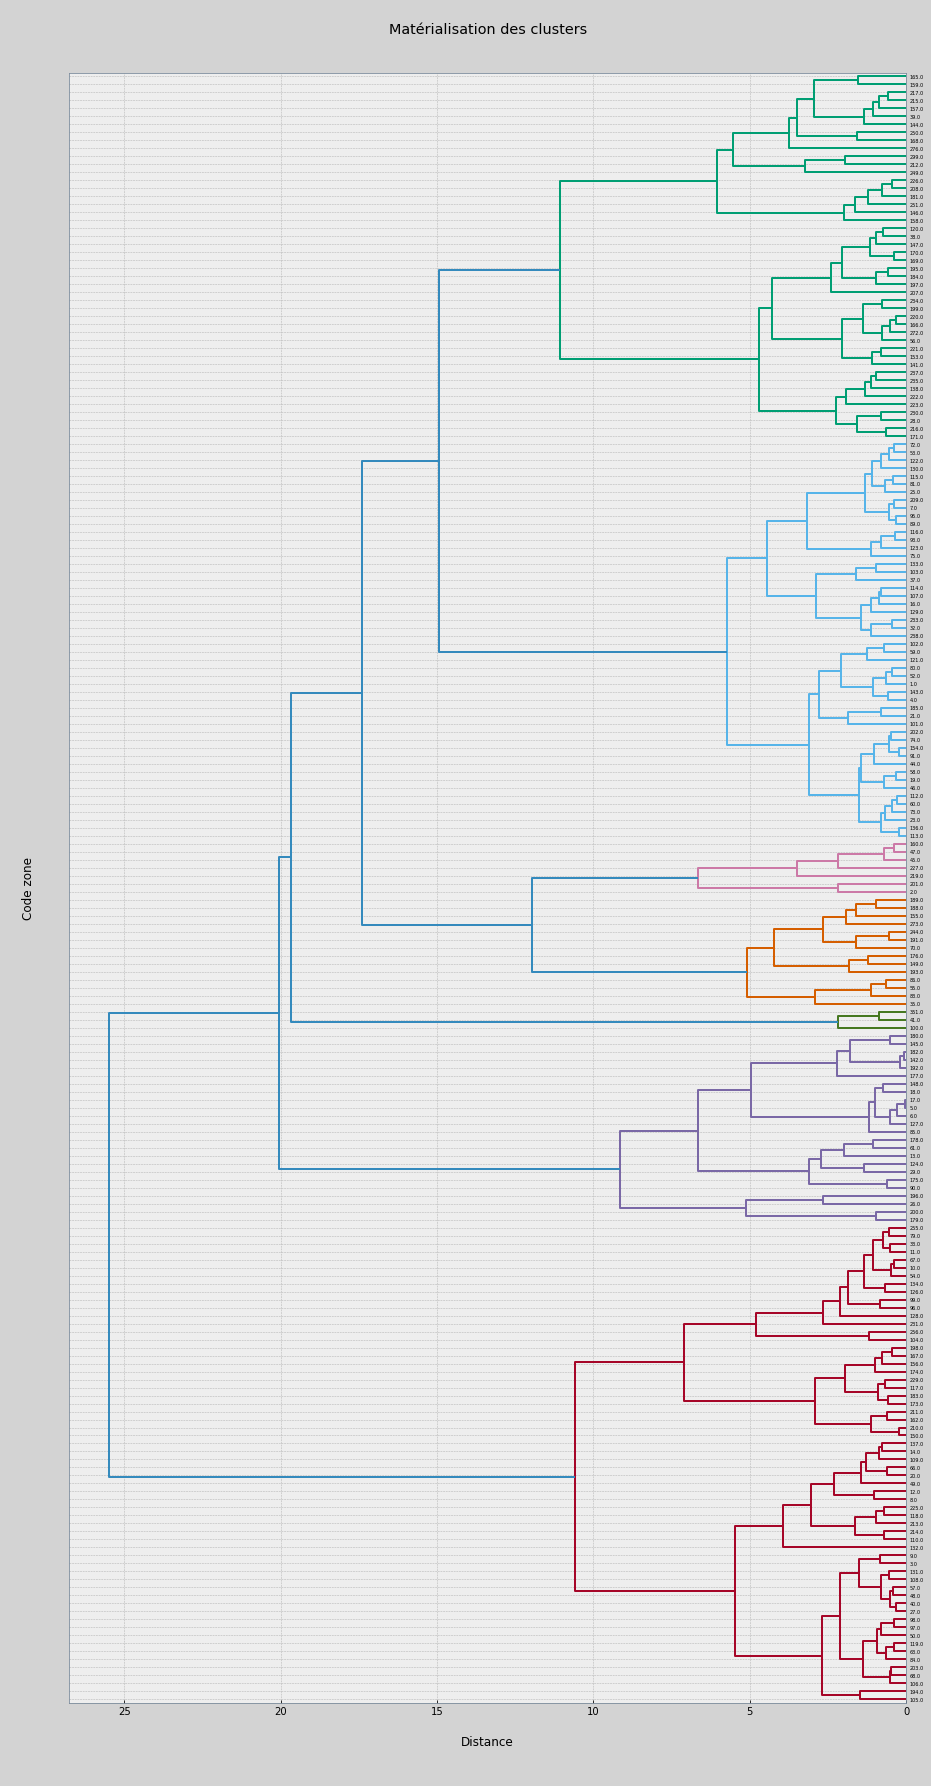

In [115]:
# dendrogramme surdécoupé
plt.figure(figsize = (15, 30))
dendrogram(
    z_20,
    labels = pays_20,
    color_threshold = 11.5,
    orientation = 'left'
)
# formalité d'affichage d'un graphe et sauvegarde
plt.title('\nMatérialisation des clusters\n\n')
plt.xlabel('\nDistance\n\n')
plt.ylabel('\nCode zone\n\n')
plt.savefig('dendrogramme_2020_final', dpi = 500)
plt.show()    

In [116]:
# enregistrement des clusters selon le découpage
cluster_cah_20 = fcluster(z_20, 7, criterion = 'maxclust')

In [117]:
# trie des index selon les appartenances aux clusters cah
cluster_20_idx = np.argsort(cluster_cah_20)

In [118]:
# création d'un df dictionnaire des code_zones et leur numéro de clusters
groupe_20 = pd.DataFrame(market_20.index[cluster_20_idx], cluster_cah_20[cluster_20_idx])

In [119]:
# colonne renommée et utilisation des index clusters comme variables
cluster_20 = groupe_20.reset_index()
cluster_20.rename(columns = {'index':'cluster_cah'}, inplace = True)

In [120]:
# injection des clusters dans le df principal Market
market_20 = market_20.join(cluster_20.set_index('code_zone'))

Clustering par la méthode des k-means avec utilisation de nom_variable pour avoir les paramètres socio_économiques de Market_20.

In [121]:
# choix du nombre de composantes principales
n_comp_km_20 = min(market_20.shape[0] + 1, len(nom_variable))

In [122]:
# clustering des données avec k-means en 7 groupes
km_20 = KMeans(n_clusters = 7)
km_20.fit(x_scaled_20)

c:\workplace\data_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=7)

In [123]:
# index de clusters pour chaque individu
cluster_km_20 = km_20.labels_

In [124]:
# calcul des composantes princiaples
pca_20 = decomposition.PCA(n_components = n_comp_km_20).fit(x_scaled_20)
x_projected_20 = pca_20.transform(x_scaled_20)

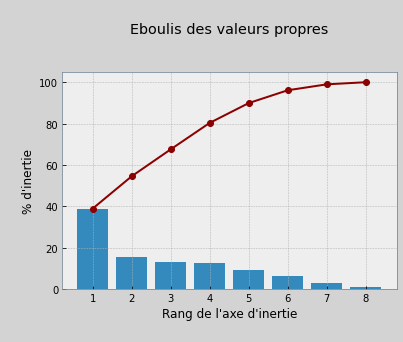

<Figure size 432x288 with 0 Axes>

In [125]:
# représentation de l'éboulis des valeurs propres
display_scree_plot(pca_20)
plt.savefig('eboulis_vp_2020', dpi = 500)

Les deux premières composantes principales représentent un plus fort taux de l'inertie totatale. Une fois encore, on notera une participation égalitaire à l'inertie totale des CP 2 à 5.

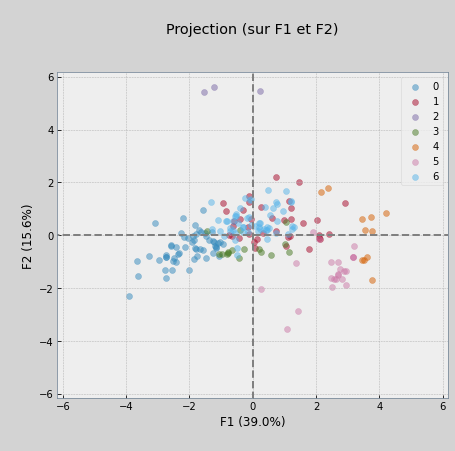

In [126]:
# projection des individus dans le 1er plan factoriel
display_factorial_plane(x_projected_20, 2, pca_20, [(0, 1)], None, .5, cluster_km_20)

- Notons le pourcentage de représentation du premier plan factoriel : 54.6.  
- Le clustering est visuellement pertinent. Remarquons tout de même une certaine anarchie dans la projection des clusters 1 et 3 dont l'inertie inter doit être proche de 0.  
Nous verrons aux tests si ce découpage est réellement pertinent.

In [127]:
# tri des clusters k-meanniens
cluster_idx_km = np.argsort(cluster_km_20)

In [128]:
# création d'un df de correspondance code_zone/cluster_km
groupage_km_20 = pd.DataFrame(market_20.index[cluster_idx_km], cluster_km_20[cluster_idx_km])

In [129]:
# renommage de colonne et utilisation des index clusters comme variables
cluster_km_20_df = groupage_km_20.reset_index()
cluster_km_20_df.rename(columns = {'index':'cluster_km'}, inplace = True)

In [130]:
# injection des clusters dans le df Market_20
market_20 = market_20.join(cluster_km_20_df.set_index('code_zone'))

In [131]:
# correspondance avec le clustering CAH
cah_km = pd.crosstab(market_20.cluster_cah, market_20.cluster_km )
cah_km

cluster_km,0,1,2,3,4,5,6
cluster_cah,,,,,,,
1,49,0,0,2,0,0,9
2,0,0,0,0,2,22,0
3,0,0,3,0,0,0,0
4,0,0,0,14,0,0,0
5,0,0,0,0,6,1,0
6,1,0,0,0,0,0,49
7,5,38,0,0,3,0,0


- Les deux clusterings présentent de légères divergences sur la composition des groupes : certains pays ayant été clusterisés différemment.  
- Nous avons deux correspondances.

In [132]:
# récupération des noms usuels des pays
bdd_cluster_20 = market_20.join(dico_zone.set_index('code_zone'))

In [133]:
# ré-initialisation du df de clusters cah et km avec suppression des code_zones
bdd_cluster_20.reset_index(drop = True, inplace = True)

In [134]:
# exportation des données clusterisées par CAH et K-means
bdd_cluster_20[['pays', 'cluster_cah', 'cluster_km']].to_csv('clustering_20_cah_et_km.csv')

Nous passons à l'étape des centroïdes.

In [135]:
# calcul des centroïdes + préparation des données
centroids_20 = km_20.cluster_centers_
centroids_projected_20 = pca_20.transform(centroids_20)

In [136]:
# préparation des données : calcul des composantes pour les projections
pcs_20 = pca_20.components_

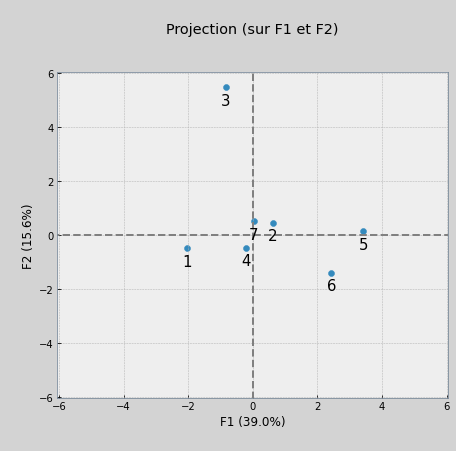

<Figure size 432x288 with 0 Axes>

In [137]:
# représentation des centroïdes sur le 1er plan factoriel
display_factorial_plane(centroids_projected_20, 2, pca_20, [(0, 1)], labels = market_20.index.astype(int), alpha = 1, illustrative_var = None)
plt.savefig('projection_centroides_f1_f2_2020', dpi = 500)

- Le premier plan factoriel capte 55% de l'inertie totale. C'est juste pour permettre une projection pertinente. Nous verrons comment se projectent les variables dans le cercle des corrélations et déciderons s'il est judicieux de faire une projection dans le 2 plan.  
- Mis à part 4 et 5, tous les centroïdes ont une forte corrélation avec la deuxième composante principale, la relation étant négative pour 1 et 6.  
- Les trois premiers clusters, très proche de l'origine, présentent également un fort degré de corrélation avec la première CP. Pour le cluster 1, nous noterons sa nature anticorrélée. La CP N°1 a également une corrélation avec le 5e cluster.

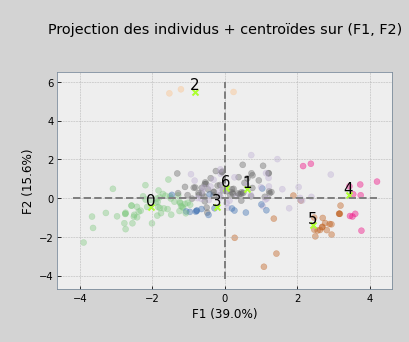

In [138]:
# projection individus + centroïdes dans (F1, F2)

# affiche les individus colorés e fonction de leur cluster
plt.scatter(
    x_projected_20[:, 0],
    x_projected_20[:, 1],
    c = cluster_km_20.astype(float),
    cmap = 'Accent',
    alpha = .4
)
# affiche les centroïdes 
plt.scatter(
    centroids_projected_20[:, 0],
    centroids_projected_20[:, 1],
    c = 'greenyellow',
    marker = 'x'
)
# numérote es centroïdes
for i, (x,y) in enumerate(centroids_projected_20[:, [0, 1]]) :
    plt.text(
        x, y + .35,
        i,
    fontsize = '15',
    ha = 'center',
    va = 'center'
    )
# affichage des lignes horizontales et verticales
plt.plot([-4.2, 4.2], [0, 0], color = 'grey', ls = '--')
plt.plot([0, 0], [-4.2, 6], color = 'grey', ls = '--')
# formalités d'affichage d'un graphe
plt.xlabel('F1 ({}%)\n'.format(round(100 * pca_20.explained_variance_ratio_[0], 1)))
plt.ylabel('\nF2 ({}%)'.format(round(100 * pca_20.explained_variance_ratio_[1], 1)))
plt.title("\nProjection des individus + centroïdes sur (F1, F2)\n\n")
plt.savefig('projection_f1_f2_individus_centrodes', dpi = 500)
plt.show(block = False)

In [139]:
# conversion en dataframe = nommage des colonnes d'après les variables usuelles
bdd_centroide_var_20 = pd.DataFrame(centroids_20, columns = bdd_cluster_20.columns[:8])

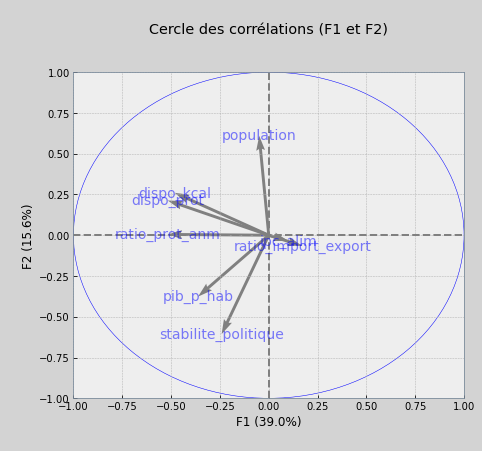

<Figure size 432x288 with 0 Axes>

In [140]:
# réprésentation des corrélations entre variables
display_circles(pcs_20, 2, pca_20, [(0, 1)], labels = market_20.columns[:8], label_rotation = 0, lims = None)
plt.savefig('cercle_correlation_f1_f2_2020', dpi = 500)

o F1 :  
- A part ratio_impor_export et ipc_alim, toutes le variables, étant à mi-parcourt du périmètre du cercle, sont (littéralement) moyennement représentée sur le premier plan factoriel;  
- Seules les deux exceptions précédentes sont en corrélation positive avec F1. Toutes les autres sont en corrélation négative, notons le cas particulier de ratio_prot_anm, en parfaite anticorrélation avec F1 => nous nous attendons à des coefficients presque nulles pour toutes composantes autre que F1.  
  
    
o F2 :  
- Stabilité socio_po et le pib sont négativement corrélées à F2;   
- La variable population a un fort degré de corrélation avec F2 (presque colinairité);  
- Dispo_kcal et prot sont positivement corrélée à F2;  
- La projection du paramètre ratio_prot_anm est orthogonale à F2 => pas de corrélation;
- A noter n°1: à cause de leur degré de corrélation respetif avec les deux premières composantes princpales, on pourrait croire que ratio_prot_anm et population sont indépendantes l'une de l'autre mais remarquons que leur projection sur ce plan n'est pas maximale => une relation de corrélation peut exister entre ces deux variables;  
- A noter n°2: le degré de corrélation de pib est le même pour F1 et F2.  
  
o Interprétation :  
- En comparant les position des centroïdes et les corrélations des composantes principales avec les variables, nous remarquons que le cluster 4 est caractérisé principalment par la population.  
- Le cluster 6 est le groupe dont la consommation nutritionnelle est le plus important et dont le pib a, relativement, le plus d'importance.  
- Le cluster 5 est "en opposition" puisque les variables nutritionnelles caractérisent le moins ses pays.  
- Le cluster 2, très proche de l'origine est davantage représenté par son pib.  
=> en résumé, seul le cluster 5 (dont le centroïde est le N°6 sur la projection) apparaît comme le meilleur candidat pour l'ouverture d'un nouveau marché du poulet or :

o 2e plan factoriel  
Une des variables les plus imortantes (ratio_iport_export) a une projection trop mauvaise dans le 1er plan factoriel. Nous décidons d'utiliser le deuxième plan.

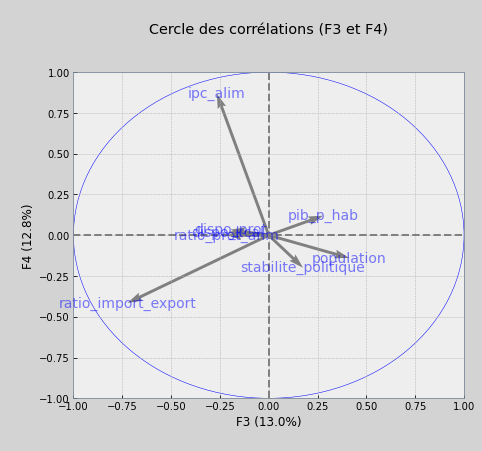

<Figure size 432x288 with 0 Axes>

In [141]:
# réprésentation des corrélations entre variables sur le 2e plan factoriel
display_circles(pcs_20, 4, pca_20, [(2, 3)], labels = market_20.columns[:8], label_rotation = 0, lims = None)
plt.savefig('cercle_correlation_f3_f4_2020', dpi = 500)

- Haaaa. Excellente représentation des variables ipc_alim et ratio_import_export puisque leur norme respective atteignent presque le rayon du cercle unitaire.  
- La qualité de leur projection et le degré entre leur représentation nous permettent de remarquer, au passage, la très faible corrélation entre ces deux variables.  
- En tant que variables complémentaires :
        -> ipc //F4~(coeff. de corrélation ~90%) et anti-co(F3, coeff. de corrélation ~25%)  
        -> ratio_imp_export est anti_corrélé à F3 + F4 mais coeff. de corrléation avec F3 ~75%   .
Nous effectuons également une projection des individus dans le 2e plan factoriel.

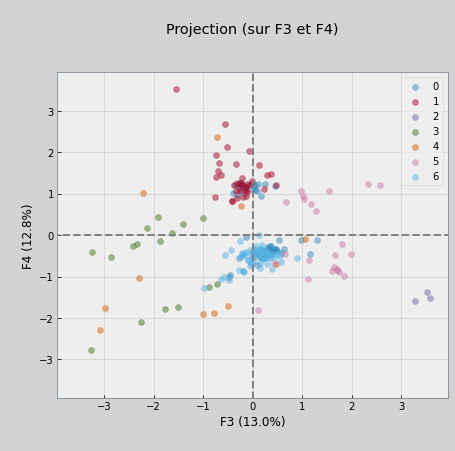

In [142]:
# projection des individus dans le 2ème 1er plan factoriel
display_factorial_plane(x_projected_20, 4, pca_20, [(2, 3)], None, .5, cluster_km_20)

- Malgré la gravitation de plusieurs individus sur le deuxième plan factoriel, l'ensemble des clusters semblent former deux amas bien distincts.  
- Mais en se penchant sur le code des couleurs, nous remarquons que le cluster 5 se répartit entre les deux amas.  
- Le 3e cluster reste bien en retrait par rapport aux autres groupes comme sur le 1er plan faactoriel.  
- Les clusters 1 et 4 restent très étalés.  
- Les clusters 2 et 3 ont une variance intra-classe très basse, ce qui est l'un des critères du clustering par la méthode de Ward.  
- Le cluster 0 est totalement explosé : on retrouve ses individus entièrement répartient sur le 2 plan factoriel.

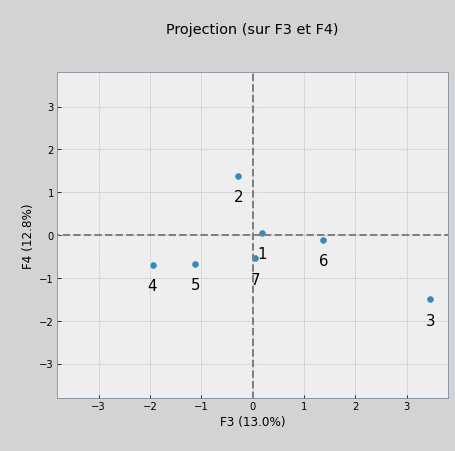

In [170]:
# représentation des centroïdes sur le 1er plan factoriel
display_factorial_plane(centroids_projected_20, 4, pca_20, [(2, 3)], labels = market_20.index.astype(int), alpha = 1, illustrative_var = None)

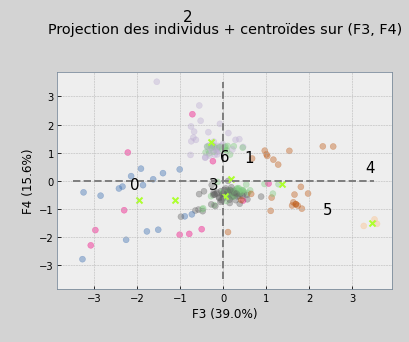

In [144]:
# projection individus + centroïdes dans (F1, F2)

# affiche les individus coloré en fonction de leur cluster
plt.scatter(
    x_projected_20[:, 2],
    x_projected_20[:, 3],
    c = cluster_km_20.astype(float),
    cmap = 'Accent',
    alpha = .4
)
# affiche les centroïdes
plt.scatter(
    centroids_projected_20[:, 2],
    centroids_projected_20[:, 3],
    c = 'greenyellow',
    marker = 'x'
)
# numerote les centroïdes
for i, (x,y) in enumerate(centroids_projected_20[:, [0, 1]]) :
    plt.text(
        x, y + .35,
        i,
    fontsize = '15',
    ha = 'center',
    va = 'center'
    )
# affichage des lignes horizontales et verticales
plt.plot([-3.5, 3.5], [0, 0], color = 'grey', ls = '--')
plt.plot([0, 0], [-3.5, 3.5], color = 'grey', ls = '--')
# formalités d'affichage d'un graphe
plt.xlabel('F3 ({}%)\n'.format(round(100 * pca_20.explained_variance_ratio_[0], 1)))
plt.ylabel('\nF4 ({}%)'.format(round(100 * pca_20.explained_variance_ratio_[1], 1)))
plt.title("\nProjection des individus + centroïdes sur (F3, F4)\n\n")
plt.show(block = False)

En comparant l'emplacement des centroïdes avec la projection des individus et le cercle des corrélations, nous remarquons que le cluster 5 (tout à gauche près de l'axe) est majoritairement caractérisé par la variable ratio_import_export. De plus en prenant en compte l'évolution imprtante de son marché durant le deux dernières années ainsi que et les observations du 1er plan factoriel, ce groupe de pays apparaît comme étant les meilleurs candidats pour l'ouverture d'un marché du poulet.

In [145]:
# expressions des centroïdes en fonction des composants princiaples
bdd_centroid_acp_20 = pd.DataFrame(centroids_projected_20, columns = ["F" + str(i+1) for i in range(8)])

In [146]:
# expression des centroïdes en fonction des deux premières composantes principales
bdd_centroid_f1_f2 = bdd_centroid_acp_20[['F1', 'F2']]

In [147]:
# df général de centroïdes : variables + acp
bdd_centroide_20 = bdd_centroid_f1_f2.join(bdd_centroide_var)

In [148]:
# réinitialisation de df
bdd_centroide_20.reset_index(inplace = True)
bdd_centroide_20.rename(columns = {'index' : 'centroide'}, inplace = True)

In [149]:
# df des composantes principales en fonction des variables
bdd_acp_fi = pd.DataFrame(pca_20.components_, columns = nom_variable, index = ["f" + str(i + 1) for i in range(8)])

In [150]:
# expression des deux premières composantes principales en fonction des variables de Market_20
bdd_acp_fi.head(2)

,ratio_prot_anm,dispo_kcal,dispo_prot,pib_p_hab,population,ipc_alim,stabilite_politique,ratio_import_export
f1,-0.518823,-0.48179,-0.517314,-0.362030,-0.048900,0.099733,-0.241248,0.171706
f2,0.004789,0.26017,0.213033,-0.376421,0.609738,-0.034938,-0.606552,-0.065623


Les valeurs des valeurs propres confirment nos observations sur les deux premières composantes princiaples faites lors de l'étude du cerlce des corrélations, à savoir que la variable synthétique F1 caractérise l'aspect nutritionnelle tandis que F2 est le caractère social-politique des pays.

In [151]:
# exportation des centroids de Market_20
bdd_centroide_20.to_csv('liste_centroide_20.csv')

#### **3. Tests** 
  
Nous l'avons visuellement remarqué lors des projections sur les plans factoriels, les représentations des clusters restent diffuses. Bien que nous ayons dégagé un profil de pays intéressant pour répondre à notre problématique, nous devons nous assurer que le clustering est réellement pertinent, autrement dit, que les clusters forment des groupes aux profils caractéristiques.  
Nous posons les hypothèses principales suivantes:  
- H0 : les clusters ne sont pas différenciés <=> leur moyenne respective sont égales;  
- H1: les clusters sont différenciers <=> les moyennes intra-clusters sont différentes.  
  
Pour ce faire, notre action se divise en deux mouvement:  
- 1 : nous allons rechercher une variable dont la distribution suit une loi normale; 
- 2 : ensuite, nous utilisons cette variable afin de tester deux clusters afin de s'assurer qu'ils diffèrent réellement l'un de l'autre.  
  
A chaque partie sont présentés le test utilisé, les raisons de ce choix et ses étapes d'exécution.

 **3.1 Sélection d'une variable témoin**  
   
Rappel: parmi les différentes variables, nous en avons besoin d'une dont la distribution soit normale. Nous n'utiliserons pas d'interprétation graphique pour évaluer la normalité des variables mais un test d'adéquation.  
  
o Choix de test  
Nous avons le choix parmi 8 variables dont:  
- effectifs de mesure > 50 unités => test de Shapiro-Wilk exclu;  
- variables = quantitative continue => test du Chi-2 exclu;  
- pas d'a priori sur les distributions => besoin d'absence de contraintes sur la distribution => test non-paramétré de Kolmogorov-Smirnov = OK.  
  
o Les hypotèses  
Nous posons:  
- H0: l'hypthèse selon laquelle la variable testée a une distribution suivant la loi normale;
- H1: la distribution de la variable en question ne suit pas la loi normale => situation de test = unilatéral => nous fixons le risque d'erreur alpha = 1%.  
  
o Environnement de test
- Statistique utilisée: Kolmogorov Dn;  
- Condition de rejet: la statistique de test dépasse un certains seuil, ici effectif n > 100 => seuil = c/√n, c = 1.517 pour alpha = 1%.  
  
o Action  
- nous construisons un df Test_ks prenant en index, les 8 variables de Market_20 et en colonne, la statistique de test et sa p-value.

In [152]:
# initialisation du df Test_ks
test_ks = pd.DataFrame(index = market_20.columns[:8], columns = ['statistique_d', 'p_value'])

In [153]:
# application du test KS puis injection dans le df test_ks
for variable in market_20.iloc[:, :8] :
    test_ks[test_ks.index == variable] = kstest(market_20[variable], 'norm')

In [154]:
test_ks

,statistique_d,p_value
ratio_prot_anm,0.843137,0.0
dispo_kcal,0.823529,0.0
dispo_prot,0.843137,0.0
pib_p_hab,0.862745,0.0
population,0.877451,0.0
ipc_alim,0.5,0.0
stabilite_politique,0.063098,0.375434
ratio_import_export,0.944729,0.0


In [155]:
# extraction des effectifs
n = market_20.stabilite_politique.shape
print("\nL'effectif des variables de Market_20 est de: n =", n[0], end = '.')


L'effectif des variables de Market_20 est de: n = 204.

- H0 est rejetée si D > c/√n;  
- n = market_20.shape[0]: le nombre d'index = 204;  
- alpha = f(c) = 1% avec f de R dans R (non exprimée ici) => c = 1.517;  
  
} => c/√n = 1.517 / √204 ~ 0.109;  
or la seule variable dont la statistique de test Dn ne dépasse ce seuil est la variable "stabilite_politique" de plus, sa p-value > risque alpha;  
  
=> l'hypothèse de nullité n'est pas rejetée. Cette hypothèse est retenue avec une confortable marge d'erreur de 1%.  
=> dans le test de comparaison de deux clusters, nous retenons les moyennes des clusters selon la variable "stabilite_politique".

 **3.2 Test de différentiation**  
   
Parce que l'ordre/numéro d'attribution des clusters ne semblent être conservés à chaque itération (à cause du principe du k-means certainement), nous allons choisir deux clusters en fonction du seul paramètre qui concerve une certaine constance: la taille. Par simplicité, nous choissisons les deux clusters ayant plus de 50 pays chacun que nous nommons arbitrairement cluster_a et cluster_b.  
Afin de les comparer, nous allons procédé à une analyse de leur moyenne respective de la variable stabilite_politique.  
  
Les étapes:  
o préparation des données;  
o analyse de l'environnement dans lequel se déroule cette comparaison;  
o choix du test en fonction de l'environnement;  
o construction des hypothèses et de la région critique;  
o test;  
o conclusion.  
  
  
o Etape 1/6: préparation des clusters A et B

In [156]:
# rappel des clusters k-meanniens
eff_cluster_km = market_20.cluster_km.value_counts()
eff_cluster_km

6    58
0    55
1    38
5    23
3    16
4    11
2     3
Name: cluster_km, dtype: int64

In [157]:
# récupération des numéros de clusters ayant les plus grands effectifs 
a, b = eff_cluster_km[eff_cluster_km.values > 50].index

In [158]:
# extraction des données concernant la variable "stab._politique" du df principal en fonction des numéros de clusters sélectionnés
cluster_a = market_20[market_20.cluster_km == a].stabilite_politique
cluster_b = market_20[market_20.cluster_km == b].stabilite_politique

o Etape 2/5 : analyse de l'environnement dans lequel se déroule la comparaison des moyennes  
  
Plusieurs aspects sont étudiés, dans l'ordre:  
- la taille des échantillons;  
- indépendances des données;  
- la loi de distribution des donnnées;  
- leur symétrie;  
- la présence d'outlier.

In [159]:
# rappel des effectifs des clusters KM choisis
cluster_a.shape[0], cluster_b.shape[0]

(58, 55)

=> n(a) = 51 et n(b) = 58  
=> test de Wilcoxon = non utilisé puisque adapté pour les échantillons de petites tailles

A cause de la nature des données, nous admettons que cluster_a et cluster_b sont indépendants l'un de l'autre, c'est aspect n'est donc pas testé.

Ensuite, nous évaluons la normalité des échantillons A et B. Un test rigoureux ayant déjà été fait, nous employons une méthode visuelle afin de gagner en temps: le q-q plot. Il nous permettra aussi de mettre en évidence d'éventuels outliers par la même occasion.  
La condition de réussite de ce "test" graphique réside dans l'alignement des points d'observations le long d'une droite (rouge, ici):  
- la 1ère bissectrice représentant le cas particulier de la distribution gaussienne;  
- d'équation y = ax + b représentant le cas général d'une loi normale notée N(b, a) avec b = espérance et a = écart-type.

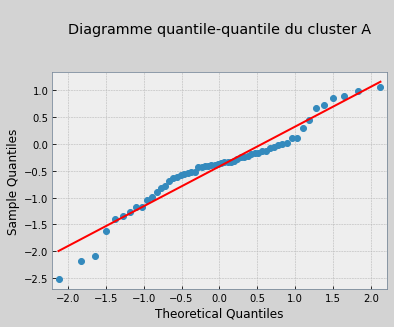

In [160]:
# q-q plot de cluster A
smi.qqplot(cluster_a, line = 'r')
plt.title('\nDiagramme quantile-quantile du cluster A\n\n')
plt.savefig('qq_plot_cluster_a', dpi = 500)
plt.show()

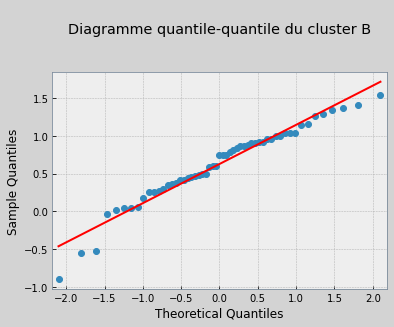

In [161]:
# q-q plot de cluster B
smi.qqplot(cluster_b, line = 'r')
plt.title('\nDiagramme quantile-quantile du cluster B\n\n')
plt.savefig('qq_plot_cluster_b', dpi = 500)
plt.show()

Parce que les données ne sont pas constantes, nous ne conclurons pas formellement. Nous dirons simplement que si les observations sont pas alignées le long de la droite rouge alors le q-q plot met en évidence un défaut de normalité qui nous permet de rejeter l'hypothèse selon laquelle la distribution des données en question suit une loi normale. De plus, si au moins un point est fortement éloigné de la dite-droite alors il s'agit d'outlier.

Intéressons-nous à la symétrie des données => calcul du skewness.

In [162]:
# calcul du skewness du cluster A
cluster_a.skew()

-0.48510467309592636

skewness(A) < 0 => distribution = asymétrique et étalée à gauche.

In [163]:
# calcul du skewness du cluster B
cluster_b.skew()

-0.731303070897987

Encore une fois, nous ne donnons pas de conclusion formelle:  
- sew = 0 => distribution = symétrie;  
- skew > 0 => distribution symétrique à gauche
- skewness < 0 => distribution de symétrie à droite et étalée à gauche;  

Concernant les outliers, nous rappellons au passage que tout point situé en dehors de l'intervalle [- 1.5 étendue interquantile; 1.5 étendue interquantile] est définit comme un outlier.  
Nous les extrayons "à la main".

In [164]:
stat_a = cluster_a.describe()
stat_b = cluster_b.describe()

In [165]:
# calcul des étendues interquantiles
eiq_a = stat_a['75%'] - stat_a['25%']
eiq_b = stat_b['75%'] - stat_b['25%']

In [166]:
# calcul des valeurs (aboslues) prises pour devenir un outlier
val_out_a = 1.5 * eiq_a
val_out_b = 1.5 * eiq_b

In [167]:
# récupération des index des observations outlières
outlier_a = cluster_a[(cluster_a.values < stat_a['25%'] - val_out_a) | (cluster_a.values > stat_a['75%'] + val_out_a)].index
outlier_b = cluster_b[(cluster_b.values < stat_b['25%'] - val_out_b) | (cluster_b.values > stat_b['75%'] + val_out_b)].index

o Etape 3/6: choix du test  
  
- Nos échantillons présentent des asymétries trop marquées et le nombre d'élément des variables regroupant les outliers est trop important =>  exclusion de test de de Student;  
- les données ne sont pas appariées => test de Wicoxon exclue;  
- les échantillons ne suivant pas une loi normale => nous choississons d'effectuer le test de Levene.

o Etape 4/6 : construction des hypothèses  et de la région critique
  
On note s_i, la variance de l'échantillon i.  
- H0: s_a² = s_b²  
- H1: s_a² != s_b²  
  
- Statistique de test: analogue à la statistique de test F, admise  
- Risque d'erreur alpha = 5%  
 
- Condition de rejet de H0: p-value du test de Levene < alpha    
- Condition de validation de H0: p-value > alpha  
  
o Etape 5/6 : test de Levene

In [168]:
stats.levene(cluster_a, cluster_b, center = 'median')

LeveneResult(statistic=1.7721341006301436, pvalue=0.1858458717116468)

o Etape 6/6 : conclusion
=> p-value > alpha  
=> H0 ne peut être rejetée  
  
Les variances ne montrant de différence significative, nous procédons à un test T afin de comparer les moyennes des deux clusters.  
  
- H0: moy_a = moy_b  
- H1: moy_a <> moy_b, moy_i, la moyenne de l'échantillon i  
  
- Condition de validation de H0: la p-value engendrée par le test T est supérieur au risque d'erreur alpha de 5%.

In [169]:
pg.ttest(
    cluster_a, cluster_b,
    paired = False,
    confidence = 0.95,
    correction = False
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-8.903353,111,two-sided,1.184717e-14,"[-1.28, -0.81]",1.675705,4.235e+11,1.0


=> p-value, 6.11 x 10^(-14) du test T est nettement inférieur à alpha, 5%;  
=> H0 est rejetée : l'écart est suffisamment important pour que les moyennes soient considérées inhomogènes;  
=> l'hypothèse de nullité principale selon laquelle les clusters ne sont pas différenciés est rejeté;e
=> le clustering effectué est significatif et ses données peuvent être exploitées pour l'étude de marché avec une marge d'erreur de 5%.